### Python Libraries and Modules Import

The following Python libraries are necessary for running the Proximal Policy Optimization (PPO) model within a Gym environment for UAV route planning. This setup also includes visualization and evaluation tools:

- `gym`: For creating and managing the simulation environment.
- `numpy`: Provides support for large, multi-dimensional arrays and matrices.
- `matplotlib` and `FuncAnimation`: For creating visualizations and animations.
- `IPython.display`: To display animations and images directly in the Jupyter Notebook.
- `stable_baselines3` and `PPO`: For implementing the PPO algorithm.
- `make_vec_env`: A utility to create a vectorized environment.
- `evaluate_policy`: A function to evaluate the policy by computing average reward.

These imports are structured to facilitate the development, testing, and demonstration of machine learning models in interactive environments.


In [1]:
%matplotlib inline
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from IPython.display import display, Video, Image
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

### UAV Environment Class Definition

The `UAVEnv` class extends the `gym.Env` class, defining a custom environment for UAV navigation and simulation. Key features and implementations in this class include:

- **Action Space**: Discrete action space with 7 possible actions representing basic movements and hovering.
- **Observation Space**: Continuous space representing UAV's position, battery status, and wind effect.
- **Initialization**: Sets the initial conditions such as target position, obstacles, battery life, environment bounds, and wind effects.
- **Step Function**:
  - Manages the UAV's movement based on the selected action.
  - Calculates battery consumption and updates the UAV's position.
  - Applies wind effects and checks for collisions with obstacles.
  - Updates the reward based on the UAV's progress towards the target and battery usage.
- **Reset Function**: Resets the environment to a predefined initial state, useful for starting new episodes.
- **Render Function**:
  - Provides a visual representation of the environment, showing the UAV's position, the target, and obstacles.
  - Utilizes matplotlib for plotting, suitable for the 'human' render mode.
- **Update Obstacles**: Optionally, obstacles can be dynamically updated during the simulation to increase complexity.

This class provides a structured and interactive way to simulate UAV navigation challenges, particularly useful for testing reinforcement learning algorithms like PPO.


In [2]:
class UAVEnv(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    
    def __init__(self, target_pos=(500, 500, 80), obstacles=None, initial_battery=6000, env_bounds=(800, 800, 120), wind_effect=None):
        super(UAVEnv, self).__init__()

        self.action_space = gym.spaces.Discrete(7)  # Basic movements + hover

        # Simplified environment parameters
        self.env_bounds = env_bounds
        self.target_pos = np.array(target_pos)
        self.initial_battery = initial_battery  # Increased battery life
        self.battery = initial_battery
        
        # Fewer static obstacles
        self.obstacles = [((400, 600), 50, 50),((600, 400), 100, 200),((200, 150), 100, 50)] if obstacles is None else obstacles
        
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 0, 0, -np.inf, -np.inf]), 
                                                high=np.array([*self.env_bounds, self.initial_battery, np.inf, np.inf]), 
                                                dtype=np.float32)

        self.wind_effect = wind_effect if wind_effect is not None else np.array([0, 0])
        self.uav_pos = np.array([0, 0, 80])

        
    def step(self, action):
        reward = 0
        done = False
        info = {}

        # Save previous position
        prev_uav_pos = np.copy(self.uav_pos)

        # Adjust battery consumption and move UAV based on action
        battery_consumption = 1  # Base consumption for movement
        vertical_movement_cost = 2  # Additional cost for vertical movement
        if action in [0, 1]:  # Up or Down
            self.battery -= vertical_movement_cost
        else:
            self.battery -= battery_consumption

        
        # Apply the movement based on the action
        movement = 10
        if action == 0:  # Up
            self.uav_pos[2] += movement
        elif action == 1:  # Down
            self.uav_pos[2] -= movement
        elif action == 2:  # Forward
            self.uav_pos[1] += movement
        elif action == 3:  # Backward
            self.uav_pos[1] -= movement
        elif action == 4:  # Left
            self.uav_pos[0] -= movement
        elif action == 5:  # Right
            self.uav_pos[0] += movement
        # Hover does not change position
        
        self.uav_pos[:2] += self.wind_effect  # Apply wind effect

        # Calculate the change in distance to target
        distance_after = np.linalg.norm(self.target_pos - self.uav_pos)
        progress = np.linalg.norm(self.target_pos - prev_uav_pos) - distance_after
        reward += progress * 10  # Multiply progress by a factor to make it more significant

    
        # Check if the UAV has reached the target
        if np.linalg.norm(self.target_pos - self.uav_pos) < 10:  # Consider a small threshold for reaching the target
            reward += 1000  # Large reward for reaching the target
            done = True
        elif self.battery <= 0:
            reward -= 50  # Smaller penalty for running out of battery
            done = True
    
        # Penalty for getting too close to obstacles
        min_distance_to_obstacle = np.min([np.linalg.norm(self.uav_pos[:2] - np.array(obstacle[0])) for obstacle in self.obstacles])
        if min_distance_to_obstacle < 50:
            reward -= 25  # Penalize proximity to obstacles
    
        observation = np.array([*self.uav_pos, self.battery, *self.wind_effect], dtype=np.float32)
        return observation, reward, done, info

    def reset(self):
        # Simplified reset logic to start from a fixed position
        self.uav_pos = np.array([100, 100, 80])  # Start from a simpler, more consistent location
        self.battery = self.initial_battery
        self.wind_effect = np.array([-5, 5])  
        return np.array([*self.uav_pos, self.battery, *self.wind_effect], dtype=np.float32)

    def render(self, mode='human'):
        if mode == 'human':
            plt.figure(figsize=(10, 10))
            plt.scatter(self.target_pos[0], self.target_pos[1], c='red', s=100, label='Target', alpha=0.5)
            plt.scatter(self.uav_pos[0], self.uav_pos[1], c='blue', s=100, label='UAV', alpha=0.5)
            for ((x, y), width, height) in self.obstacles:
                plt.gca().add_patch(plt.Rectangle((x, y), width, height, color='grey', alpha=0.7))
            plt.text(0.95, 0.01, f'Wind: {self.wind_effect[0]:.2f}, {self.wind_effect[1]:.2f}', 
                     verticalalignment='bottom', horizontalalignment='right',
                     transform=plt.gca().transAxes, color='green', fontsize=15)
            plt.xlim(0, self.env_bounds[0])
            plt.ylim(0, self.env_bounds[1])
            plt.xlabel('X Position')
            plt.ylabel('Y Position')
            plt.title('UAV Navigation Environment')
            plt.legend()
            plt.grid(True)
            plt.show()



    def update_obstacles(self):
        for idx, ((x, y), width, height) in enumerate(self.obstacles):
            new_position = np.array([x, y]) + np.random.randint(-10, 11, size=2)
            self.obstacles[idx] = (new_position.tolist(), width, height)
    
    def seed(self, seed=None):
        np.random.seed(seed)



### UAV Environment Interaction

The code below demonstrates the initialization and interaction with the `UAVEnv` environment for UAV navigation and simulation. Here's what each part does:

- **Environment Initialization**: Creates an instance of the `UAVEnv` class.

- **Environment Reset**: Resets the environment to the initial state, providing the starting observation of the UAV.

- **Simulation Loop**:
  - The loop is set to run for a specified number of steps (`num_steps`), which is set to 1 in this example for simplicity.
  - A random action is selected from the action space of the environment (`env.action_space.sample()`).
  - The selected action is applied to the environment using the `step` method, which returns the new observation, reward, whether the episode is done, and additional info.
  - The `render` method is called to visualize the current state of the environment.
  - If the `done` flag is returned as `True`, indicating that the episode has ended (e.g., the UAV has reached its target or the battery has run out), the loop breaks.

- **Reset for a New Episode**: Optionally, after the loop, the environment can be reset again to start a new episode.

This setup is ideal for testing and debugging the UAV's behavior under different actions and seeing the immediate outcome of a single step in the environment.


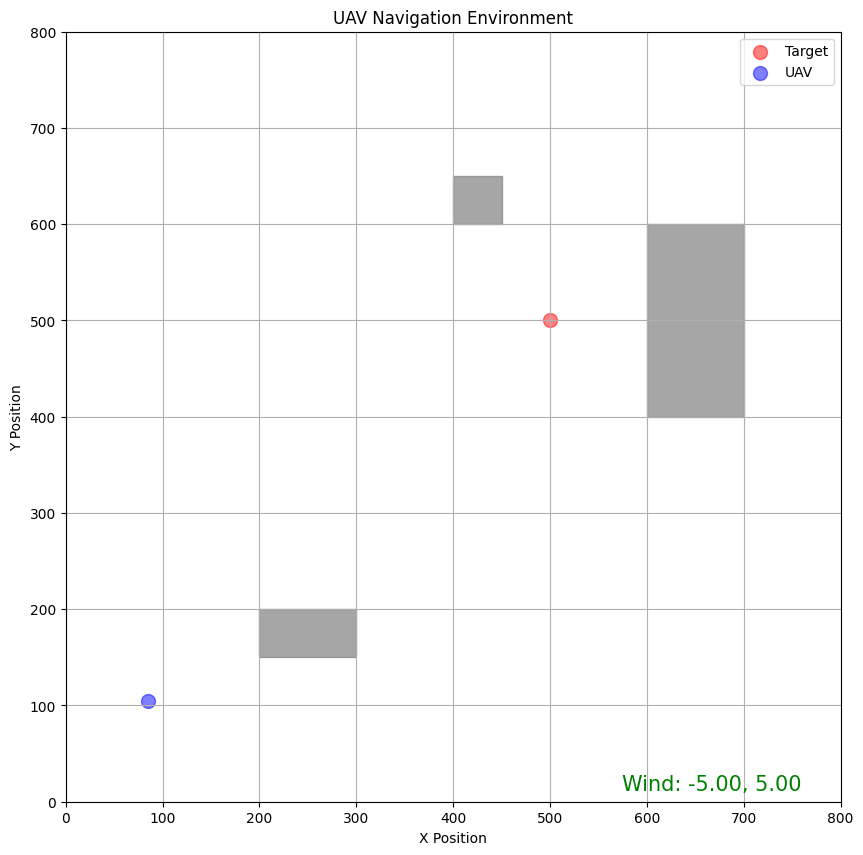

array([ 1.e+02,  1.e+02,  8.e+01,  6.e+03, -5.e+00,  5.e+00],
      dtype=float32)

In [3]:
# Create the environment instance
env = UAVEnv()

# Reset the environment to the initial state
observation = env.reset()
# Number of steps you want to take
num_steps = 1

# Take a few steps in the environment with random actions
for step in range(num_steps):
    action = env.action_space.sample()  # Choose a random action
    observation, reward, done, info = env.step(action)  # Apply the action
    env.render()  # Visualize the environment state

    if done:
        break  # End the loop if the episode is done

# Optionally, you can reset the environment again to start a new episode
env.reset()


### Animate UAV Navigation in the Environment

The `animate_environment` function provides a visual animation of the UAV moving within the simulated environment over a series of steps. It utilizes Matplotlib's animation capabilities to dynamically update the UAV's position based on the actions it takes. Here's a detailed breakdown of the function:

- **Figure and Axes Setup**:
  - A figure and a single subplot are created with `fig, ax = plt.subplots()`.
  - The plot limits are set based on the environment bounds to ensure all movements are within view.

- **Initial Plotting**:
  - The target is plotted as a red dot (`'ro'`), and the UAV's initial position is set as a blue dot (`'bo'`).
  - Obstacles in the environment are visualized as rectangles. These are not filled (`facecolor='none'`) to highlight their outlines.

- **Animation Functions**:
  - `init()`: Initializes the animation by clearing the UAV's data, ensuring it starts without any pre-existing path.
  - `animate(i)`: Called for each frame of the animation to update the UAV's position. This function:
    - Samples an action from the environment's action space.
    - Applies this action to the environment, which returns the new observation and status (done flag).
    - Updates the UAV's plot data with its new position.
    - Resets the environment if the episode is completed (when `done` is True).

- **Creating the Animation**:
  - `FuncAnimation` is used to create the animation object. It specifies the figure, the update function, the initialization function, the number of frames, and the interval between frames.
  - `plt.close(fig)` is used to prevent displaying a static image of the last frame in addition to the animation.

- **Optional Implementations**:
  - Updating obstacle positions dynamically if they are designed to move.
  - Visualizing the effect of wind on the UAV's trajectory (not implemented here).

This animation function is particularly useful for visualizing the learning process of the UAV in real-time and can aid in debugging and enhancing the UAV's pathfinding algorithms.


In [4]:
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

def animate_environment(env, num_steps=100):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim((0, env.env_bounds[0]))
    ax.set_ylim((0, env.env_bounds[1]))

    # Plotting the target
    ax.plot(env.target_pos[0], env.target_pos[1], 'ro', label='Target')
    # UAV initial position
    uav, = ax.plot([], [], 'bo', label='UAV')

    # Visualizing obstacles
    for (x, y), width, height in env.obstacles:
        ax.add_patch(patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none'))

    # Function to initialize the animation
    def init():
        uav.set_data([], [])
        return (uav,)

    # Animation update function
    def animate(i):
        action = env.action_space.sample()
        obs, _, done, _ = env.step(action)
        uav.set_data([obs[0]], [obs[1]])
        
        if done:
            env.reset()
        
        # Optional: Update obstacle positions if they are dynamic (not shown here)
        # Optional: Visualize wind effect direction (not implemented)

        return (uav,)

    # Creating the animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=num_steps, interval=200, blit=True)
    plt.close(fig)  # Prevent duplicate display of the last frame
    return anim

### Training UAV with PPO Using Stable Baselines3

The code below outlines the process for training a UAV navigation model using the Proximal Policy Optimization (PPO) algorithm. This model is trained in a custom Gym environment designed for UAV navigation.

- **Environment Setup**:
  - `make_vec_env` is used to create a vectorized environment, which allows multiple instances of the environment to be simulated in parallel. This is useful for more efficient training.
  - `UAVEnv()` defines the custom environment, which is passed as a lambda function to ensure fresh environments in each instance.

- **Model Configuration**:
  - `PPO("MlpPolicy", env, verbose=1)`: Initializes a PPO agent with a Multi-Layer Perceptron (MLP) policy. Verbose output is enabled for training progress.
  - `learning_rate=0.0005`: Sets a modest learning rate for the optimization process.
  - `ent_coef=0.01`: The entropy coefficient, which encourages exploration by penalizing low entropy in the policy.
  - `n_steps=2048`: The number of steps to run for each environment per update.
  - `batch_size=32`, `n_epochs=10`: Configures the batch size and the number of epochs to train on the data collected from each set of steps.
  - `gamma=0.99`, `gae_lambda=0.95`: Discount factors for the model which affect how much future rewards are taken into account.
  - `clip_range=0.2`: The clipping range for the PPO clip function, limiting the variation of policy updates.
  - `policy_kwargs`: Defines the architecture of the policy and value networks, both using two layers with 128 and 64 neurons respectively.

- **Training the Model**:
  - `model.learn(total_timesteps=int(total_timesteps))`: Starts the training process, running for a specified number of timesteps (`total_timesteps = 20000`), which defines how long the training will run.

- **Evaluating the Trained Agent**:
  - `evaluate_policy(model, env, n_eval_episodes=20)`: Evaluates the trained model by testing it on 20 episodes. This function calculates the mean reward, which is a measure of the agent's performance.
  - The mean reward is then printed, providing insight into how well the model has learned to navigate the UAV through the environment.

This approach to training and evaluation is essential for developing robust UAV navigation systems that can efficiently handle real-world operational scenarios.


In [5]:
env = make_vec_env(lambda: UAVEnv(), n_envs=4)
model = PPO("MlpPolicy", env, verbose=1,
            learning_rate=0.0005,  
            ent_coef=0.01,  
            n_steps=2048,
            batch_size=32,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            policy_kwargs=dict(net_arch=dict(pi=[128, 64], vf=[128, 64])))
# Training the model
total_timesteps = 20000  
model.learn(total_timesteps=int(total_timesteps))

# Evaluating the trained agent
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward}")

C:\Users\ammar\myuav\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 3244 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 8192 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 935         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.016457766 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | -0.000336   |
|    learning_rate        | 0.0005      |
|    loss                 | 5.6e+05     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0387     |
|    value_loss           | 1.24e+06    |
-----------------------------------------
-----------------

### Visualizing UAV Navigation Using a Trained Model

This script provides a step-by-step visualization of a UAV navigating through an environment using a trained model. Here's a breakdown of the process:

- **Environment Initialization**:
  - A single instance of the `UAVEnv` is created.
  - The environment is reset, and the initial observation is retrieved.

- **Path Tracking Setup**:
  - Two lists, `path_x` and `path_y`, are initialized to store the UAV's path coordinates over time.

- **Simulation Loop**:
  - The loop iterates through a predetermined number of steps (`num_steps = 200`).
  - At each step:
    - The current UAV position is appended to the `path_x` and `path_y` lists.
    - The `render` method is called to visualize the current state of the environment. This includes plotting the UAV, target, and obstacles.
    - The trained model predicts the next action based on the current observation (`model.predict(obs, deterministic=True)`).
    - This action is then applied to the environment using the `step` function, which updates the observation, returns the reward, and indicates whether the episode is completed (`done`).
    - If the episode ends (i.e., the UAV reaches its target or runs out of battery), a message is printed, and the loop exits.
    - A short pause (`time.sleep(0.05)`) is included to slow down the animation for better visibility.

- **Environment Cleanup**:
  - If the environment has a `close` method, it's called to properly close and clean up resources.

- **Plotting the UAV's Path**:
  - After the simulation, a plot is generated showing the entire path the UAV took during the episode.
  - The target position is marked with a red dot, obstacles are outlined, and the UAV's path is drawn as a blue line.
  - A legend is added for clarity.

This visualization technique is particularly useful for evaluating the effectiveness and behavior of the trained navigation model in a controlled environment.


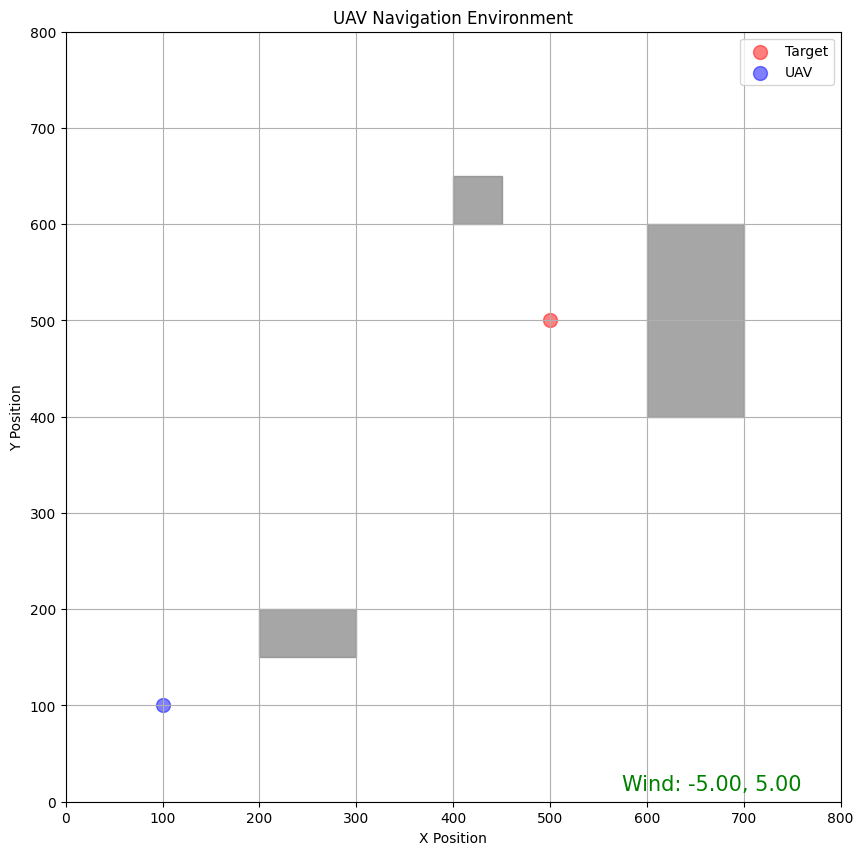

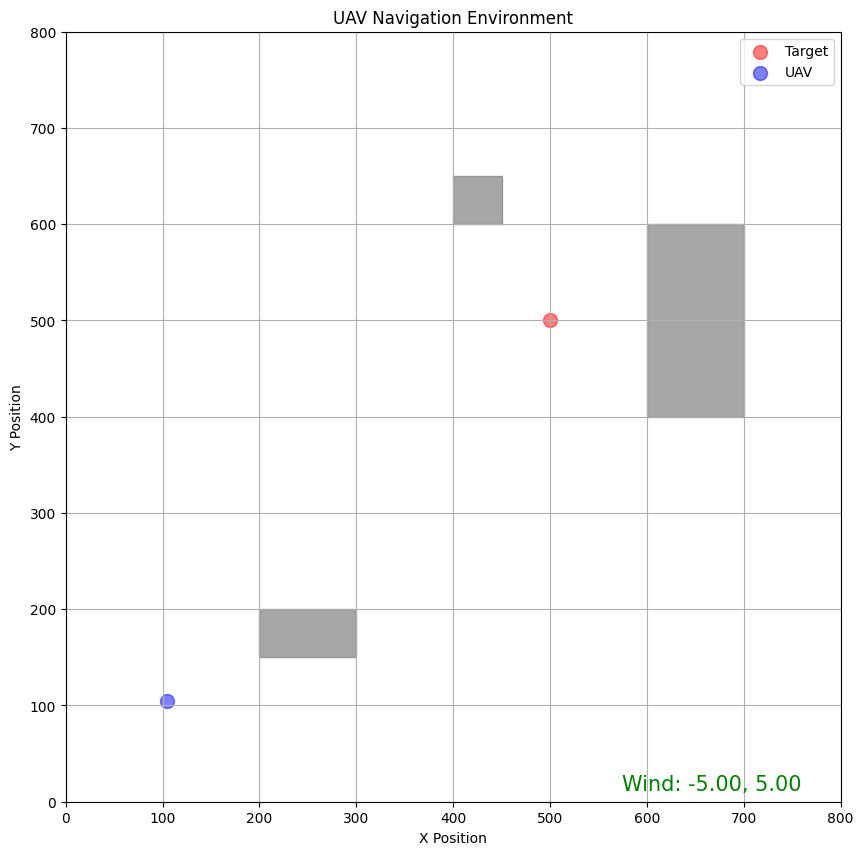

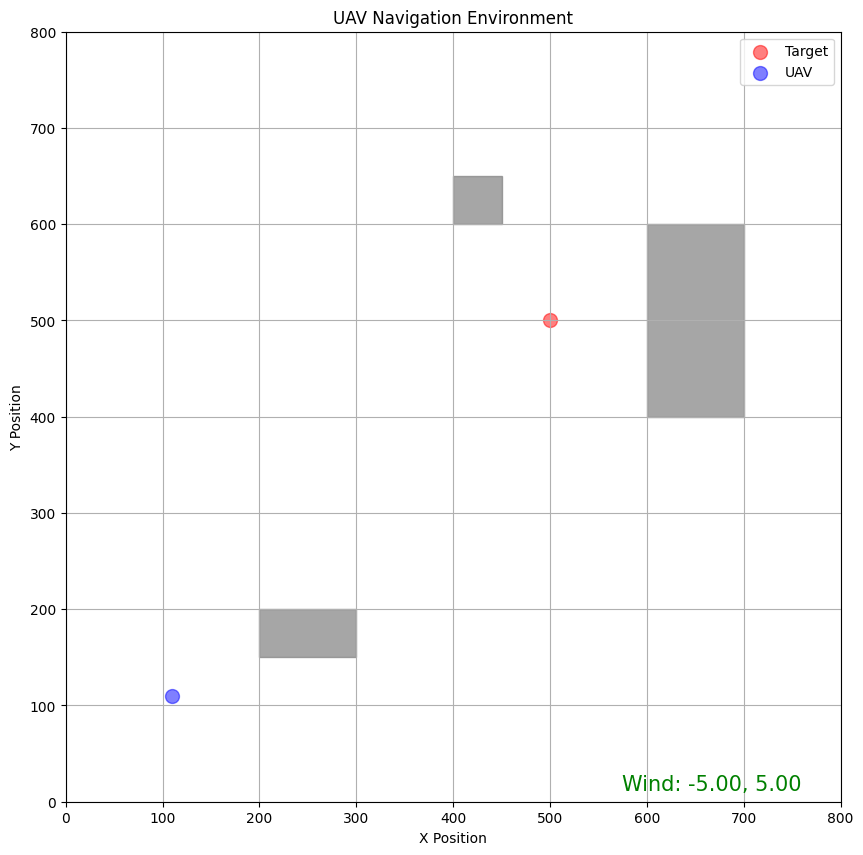

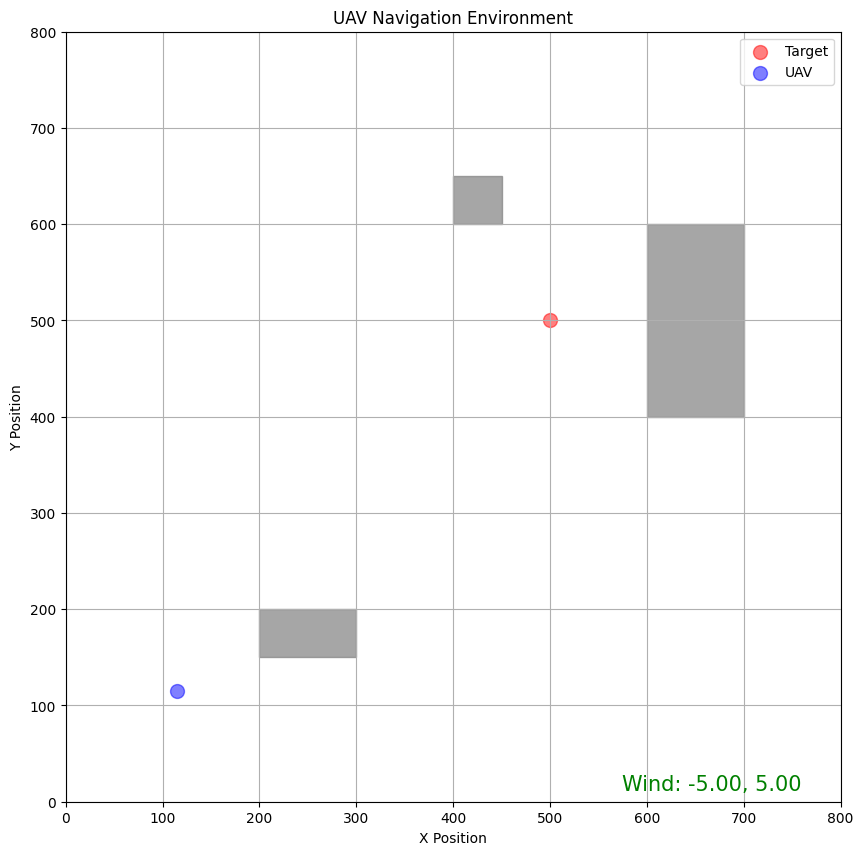

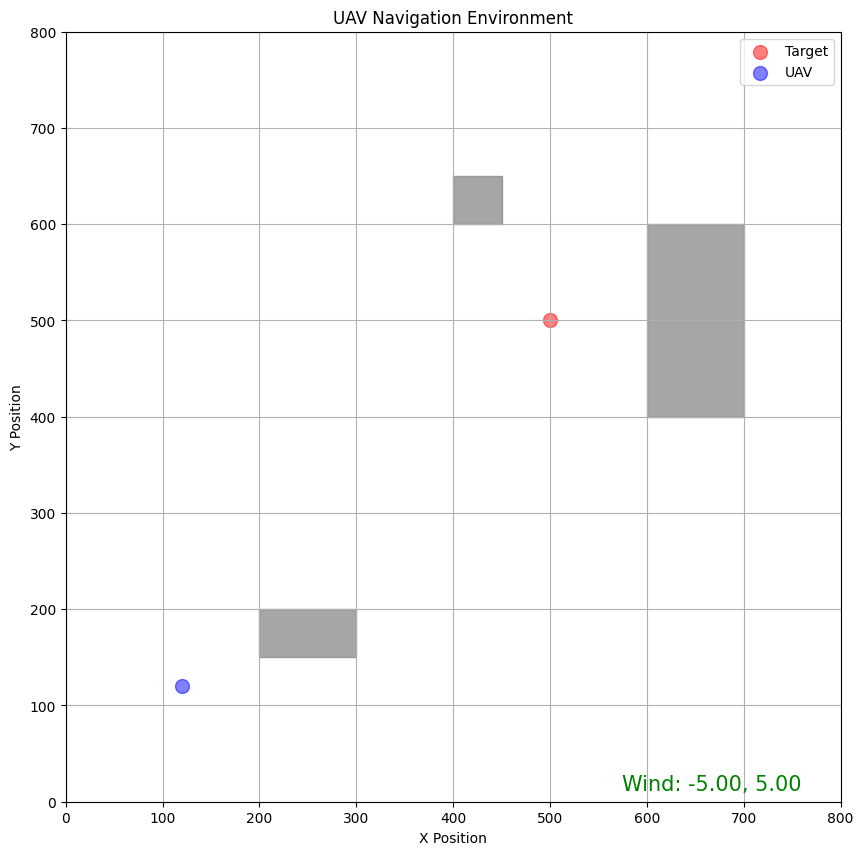

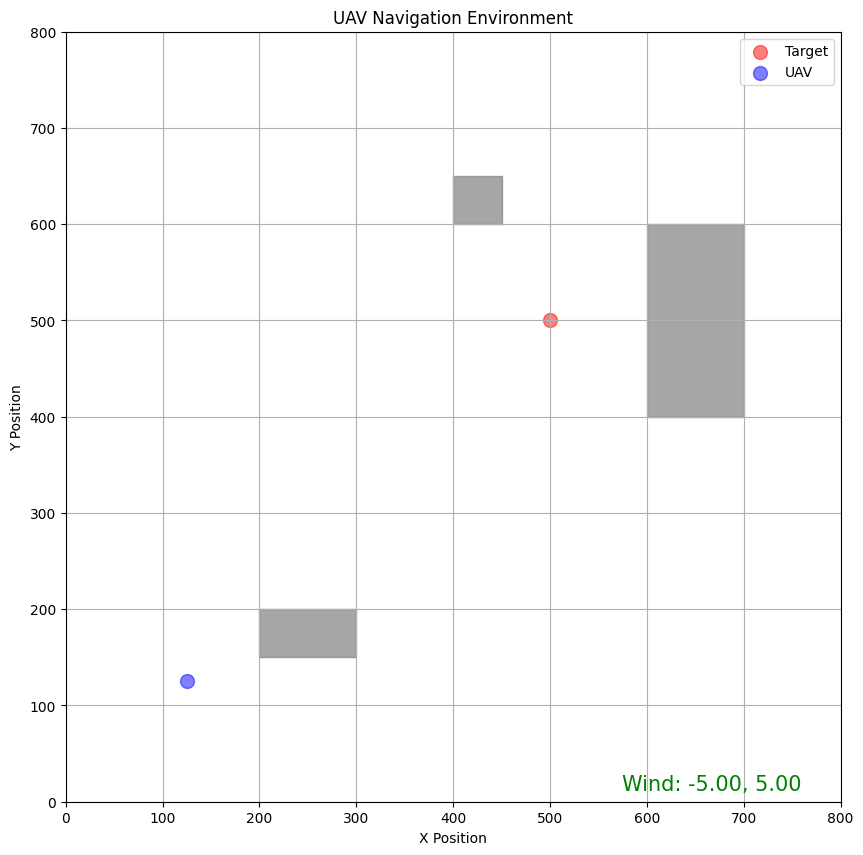

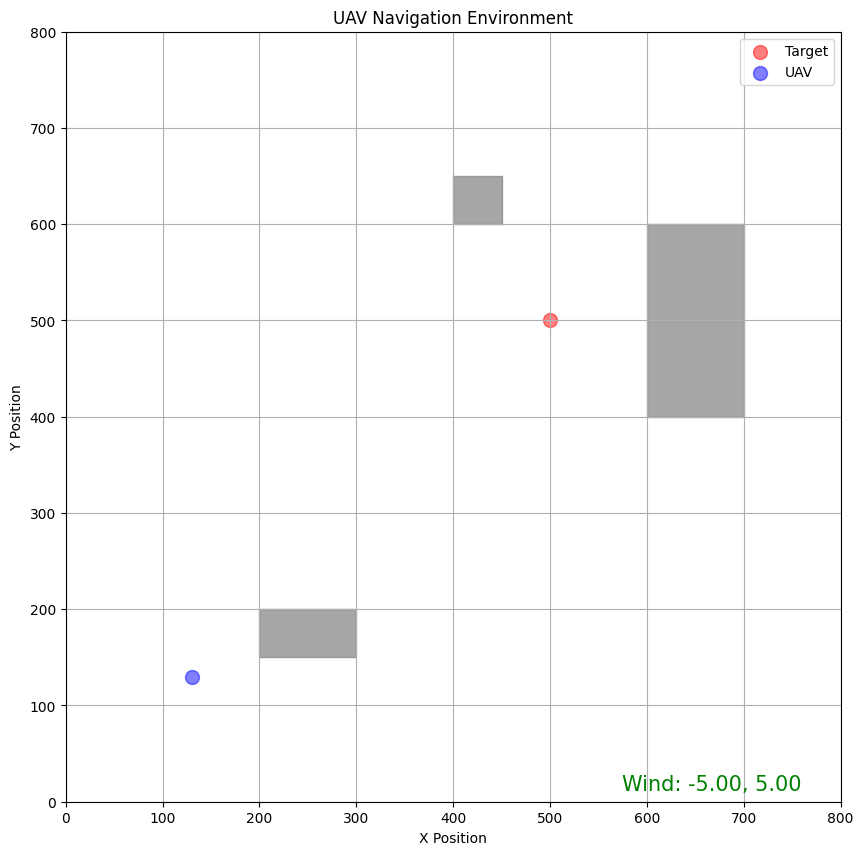

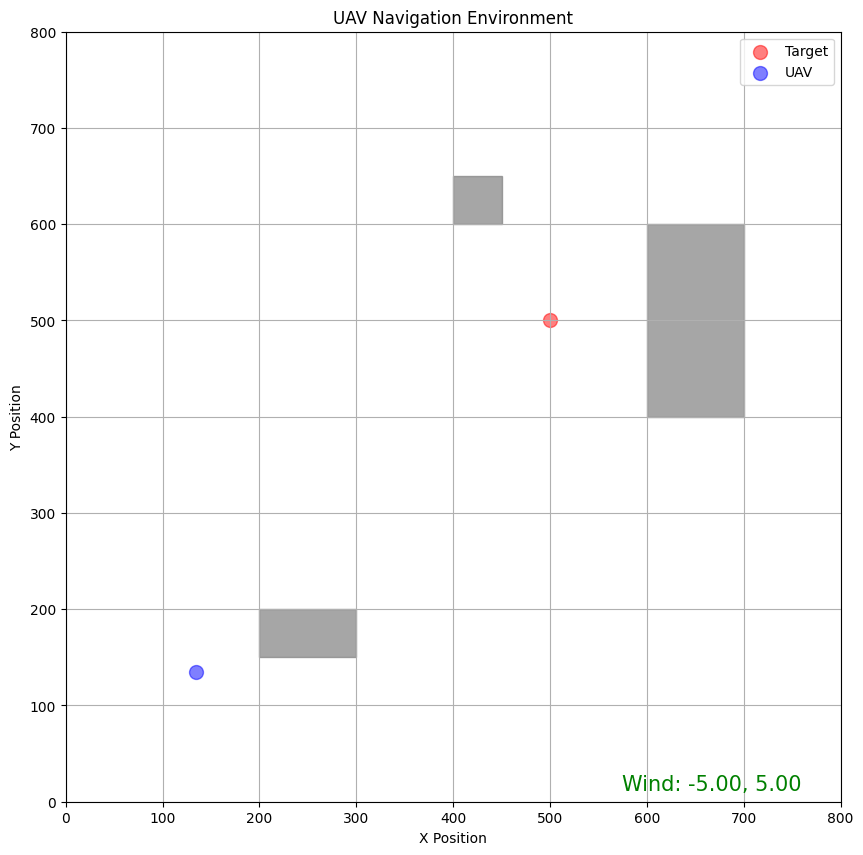

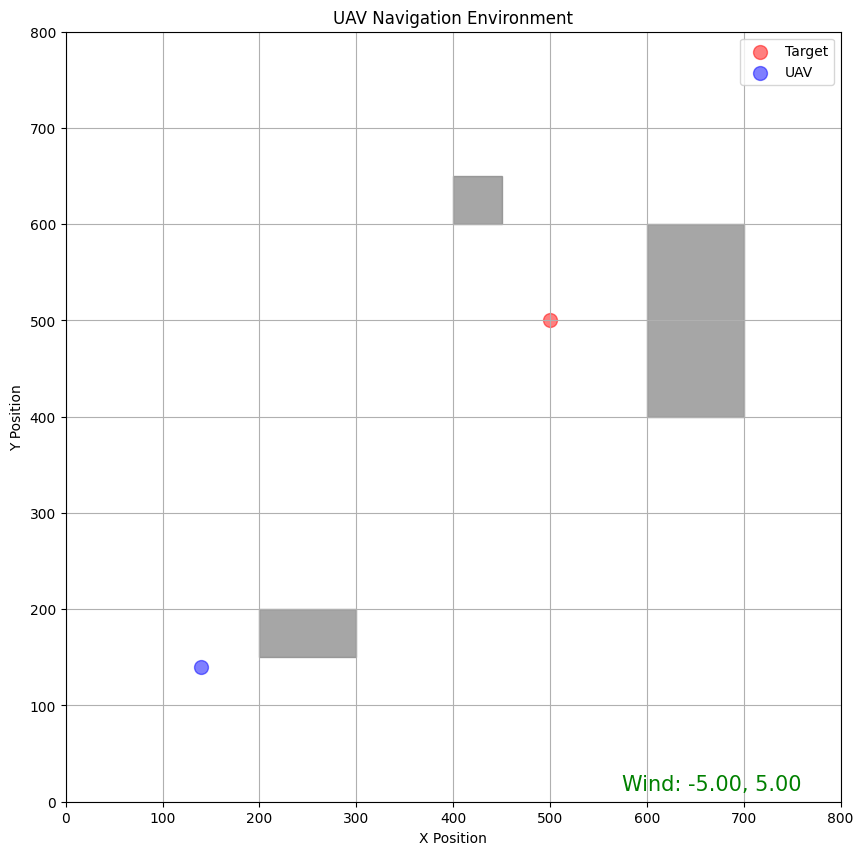

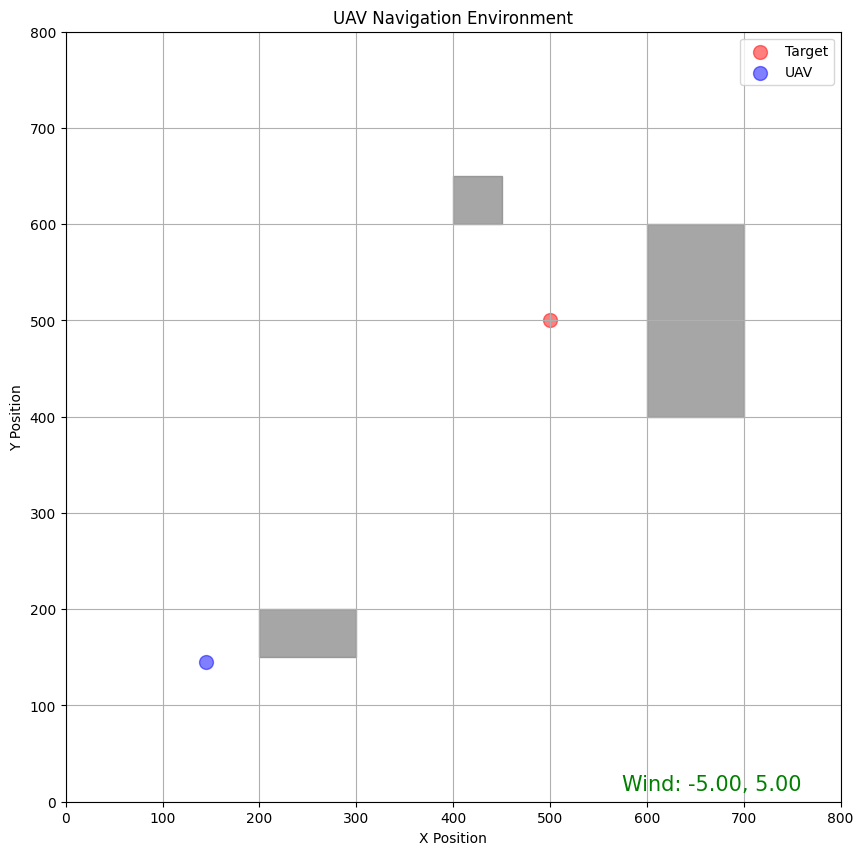

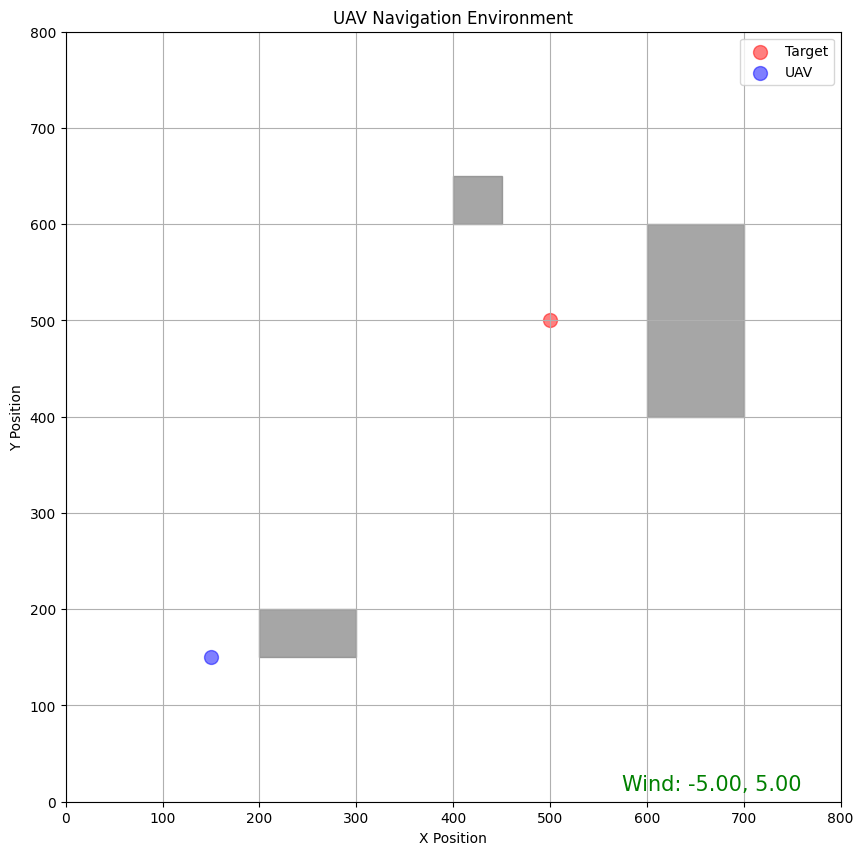

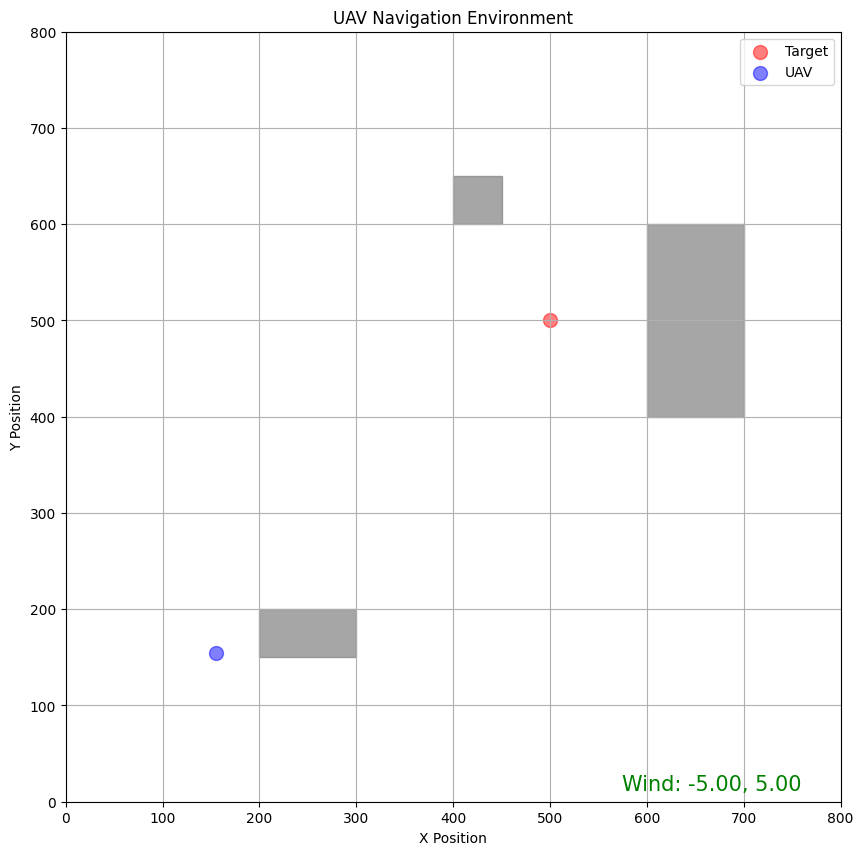

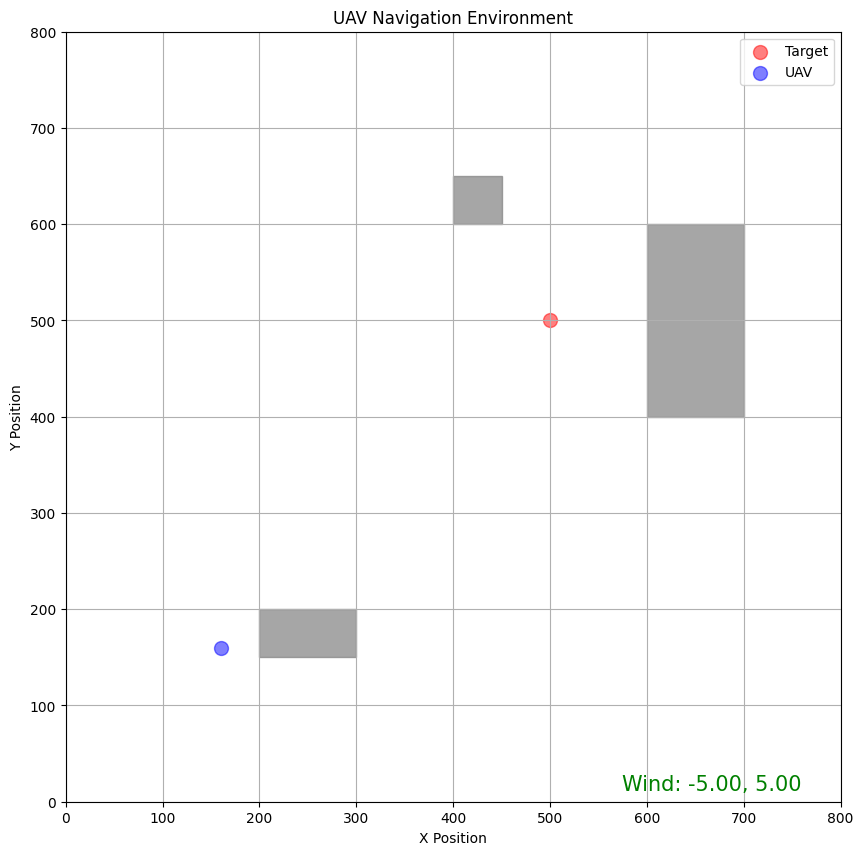

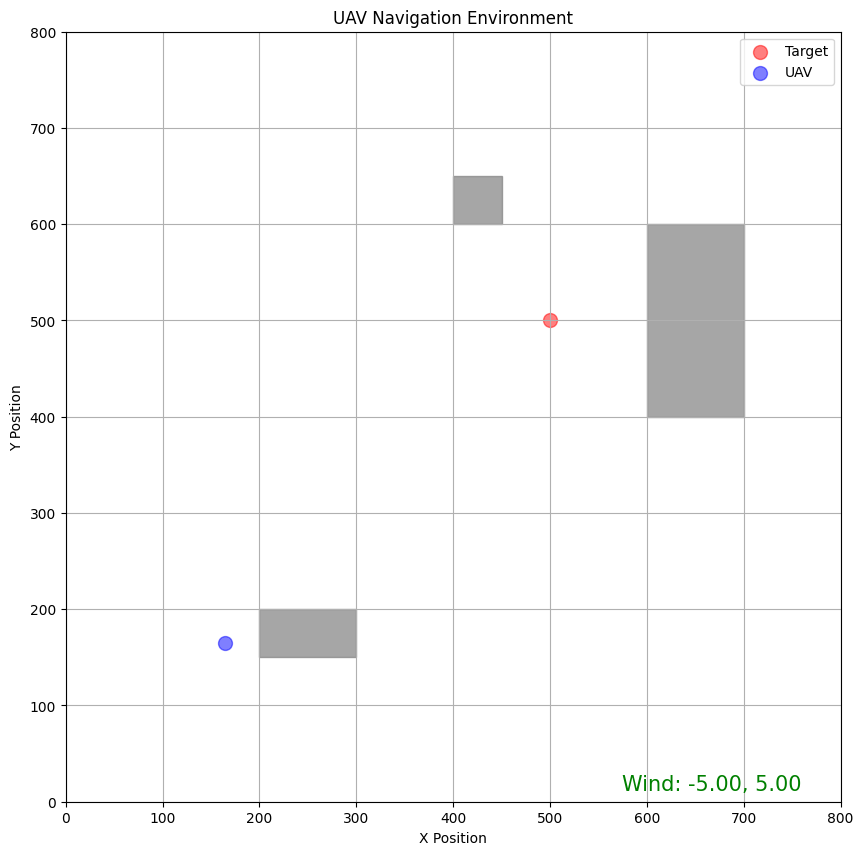

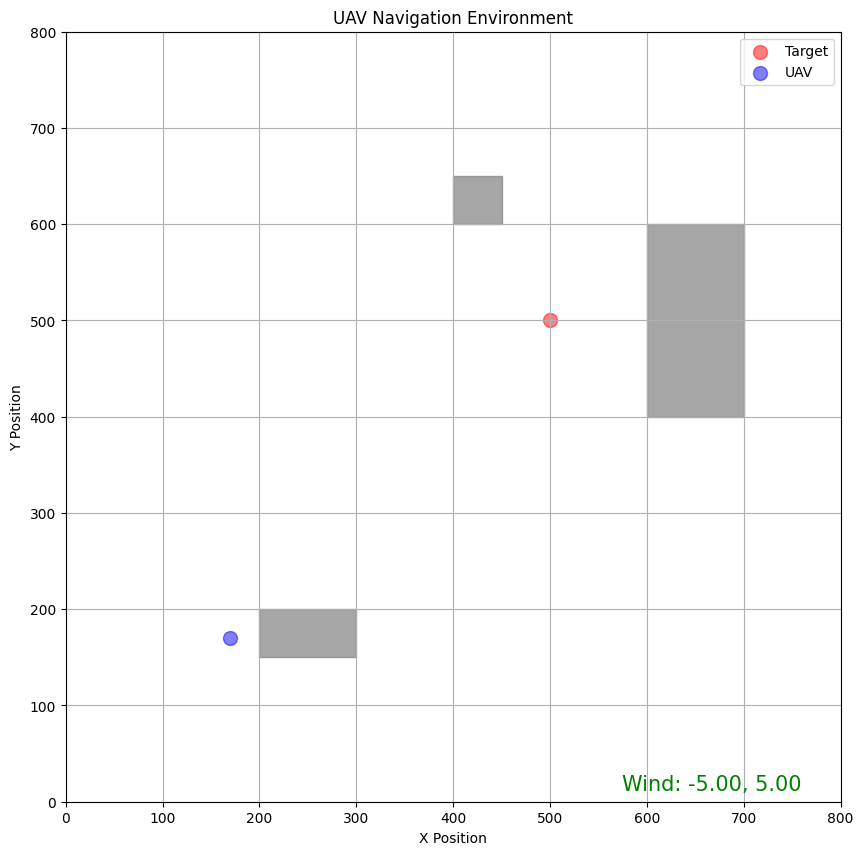

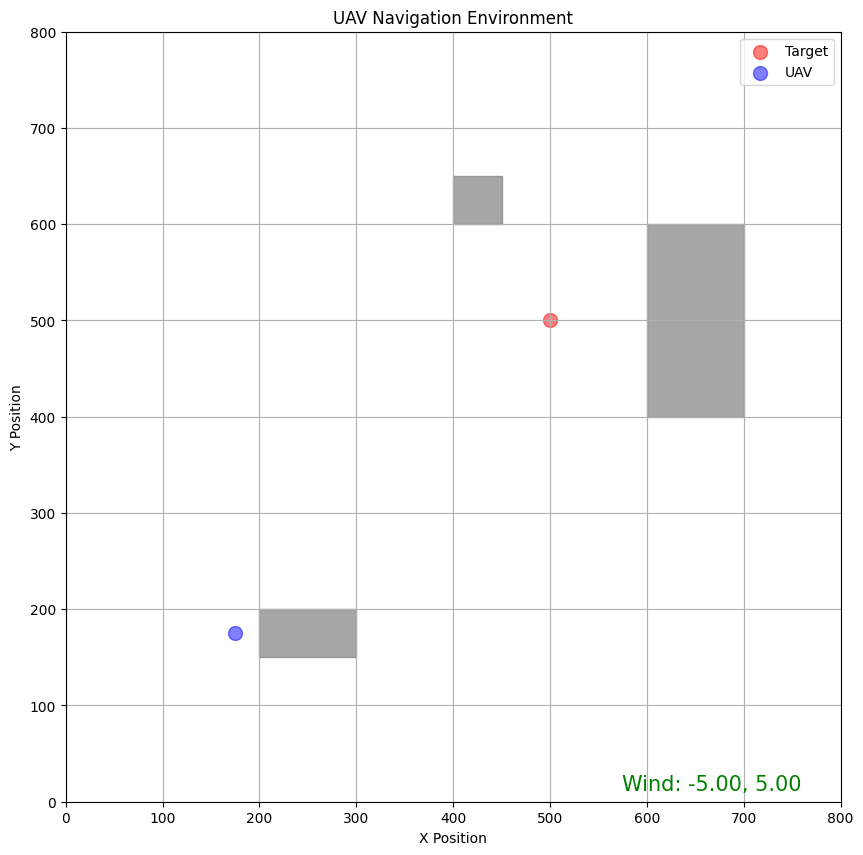

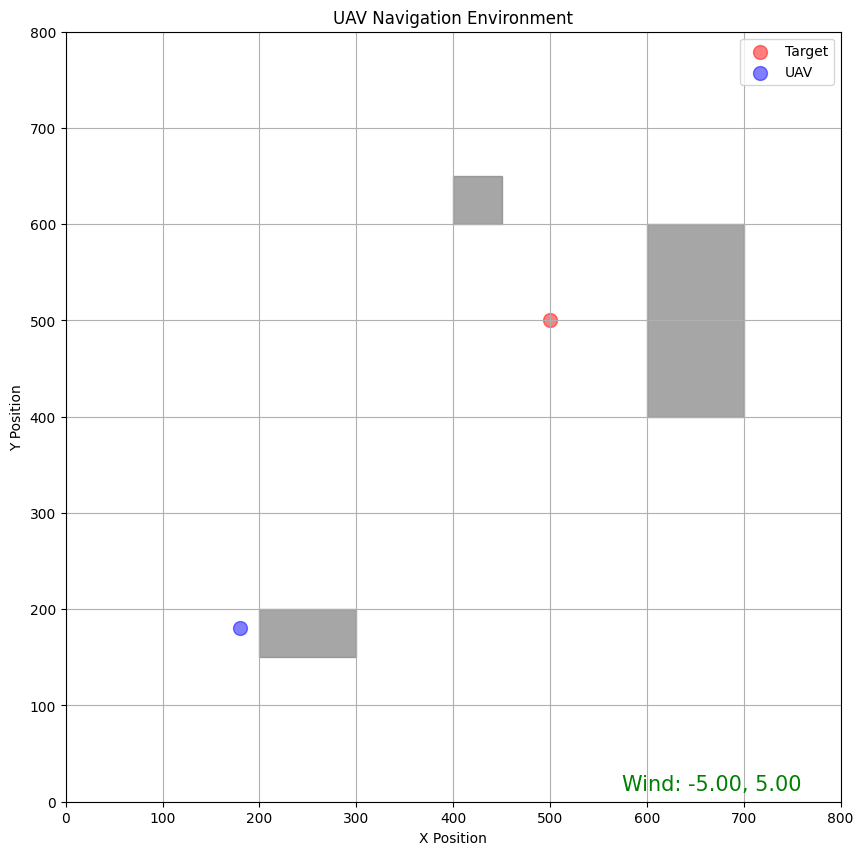

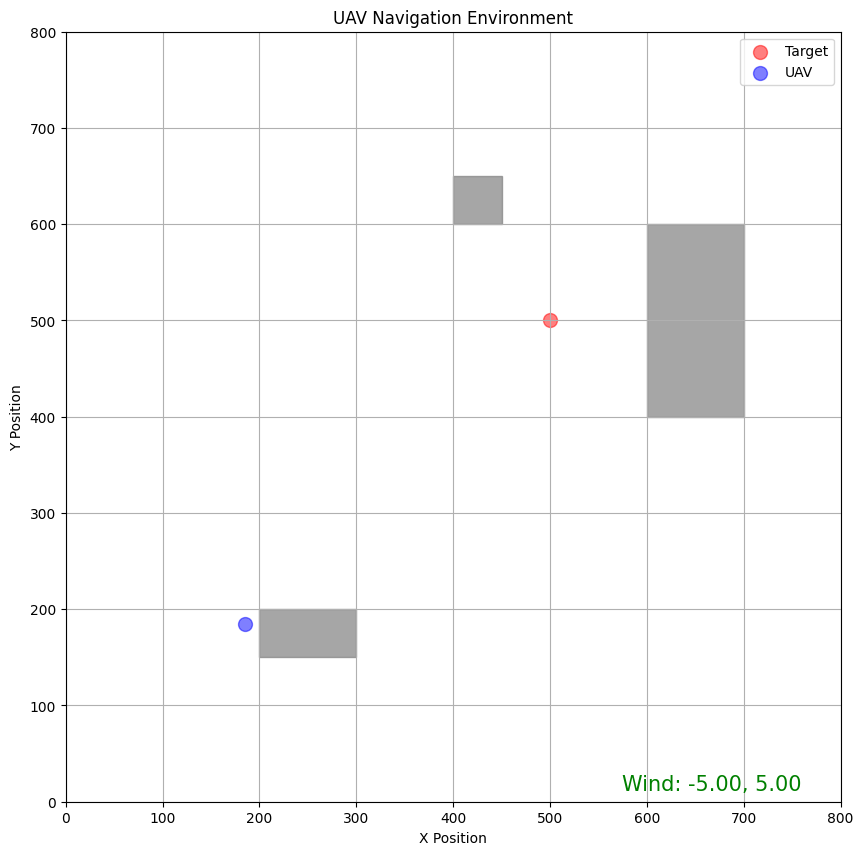

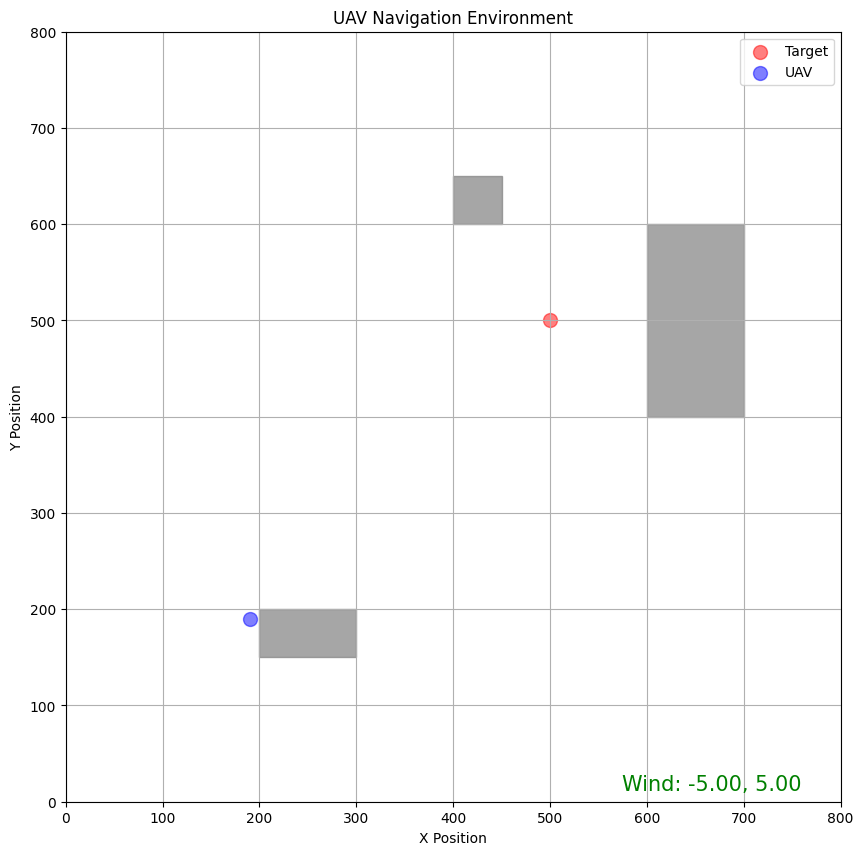

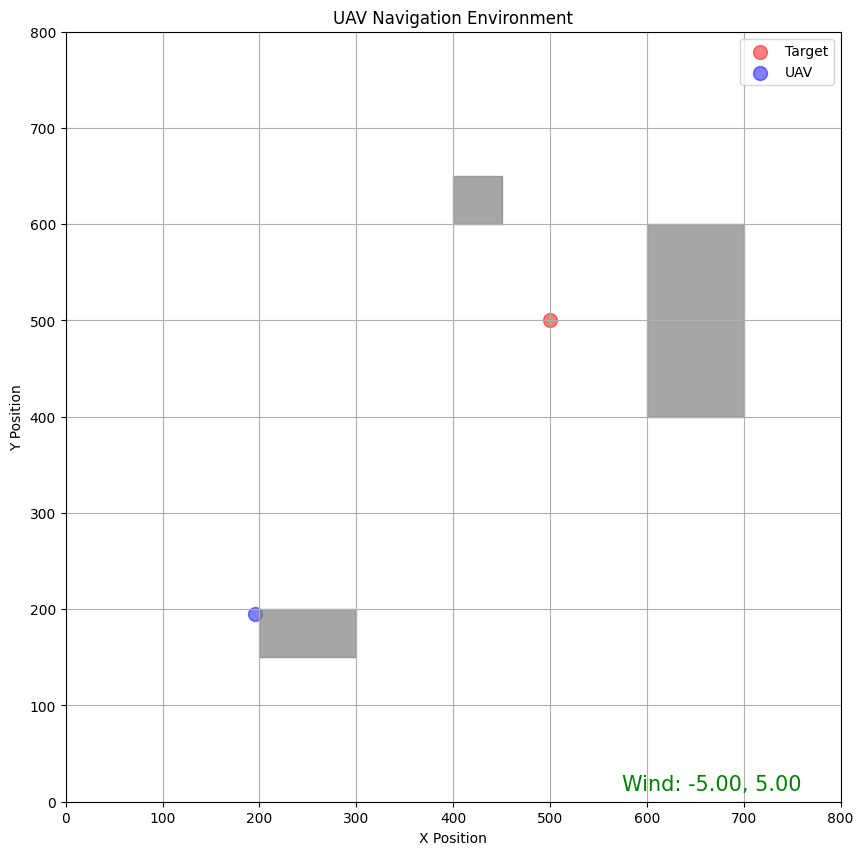

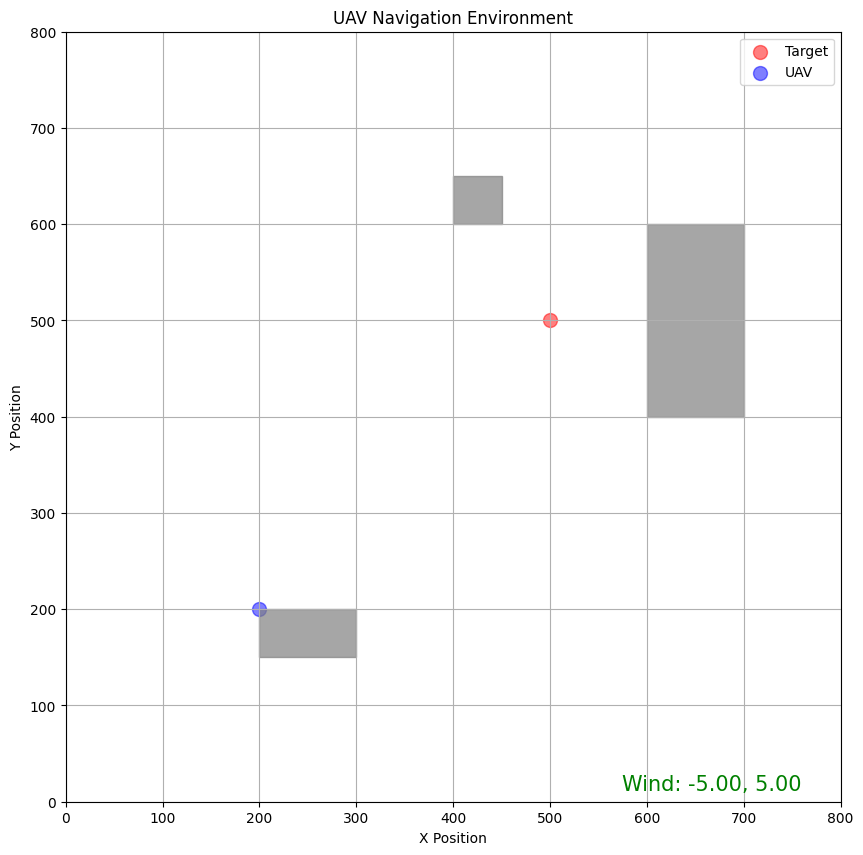

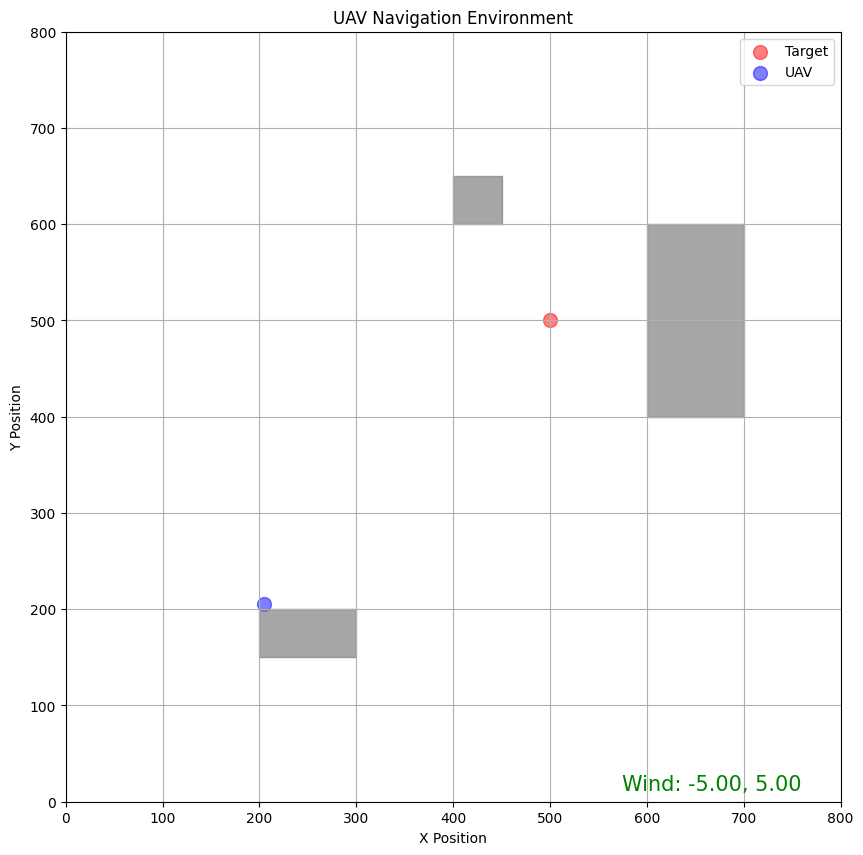

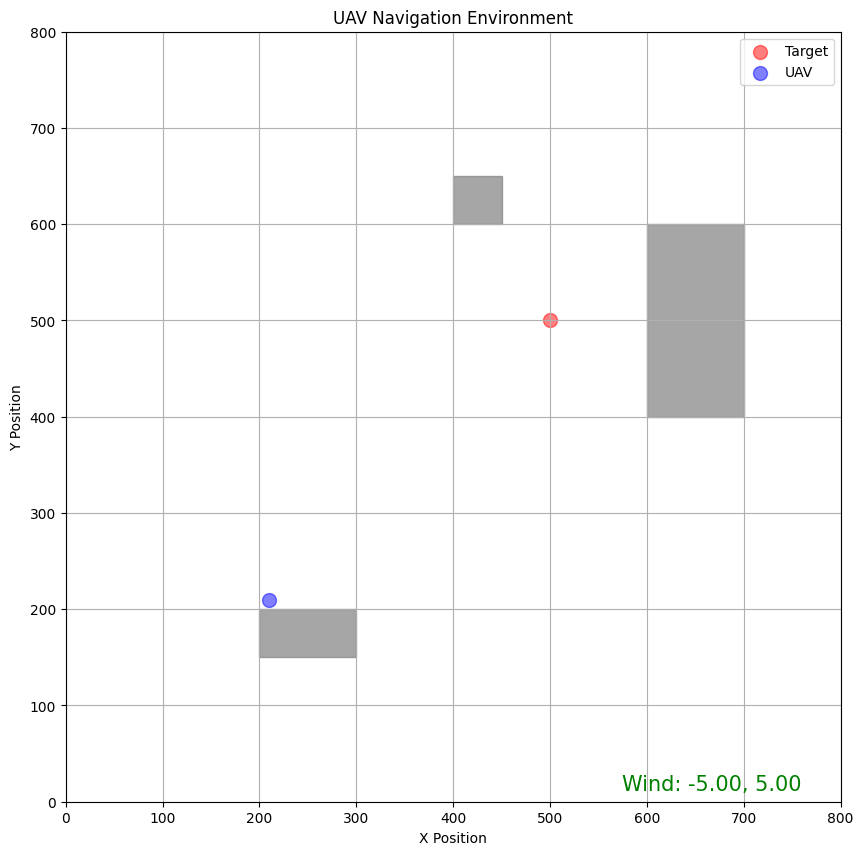

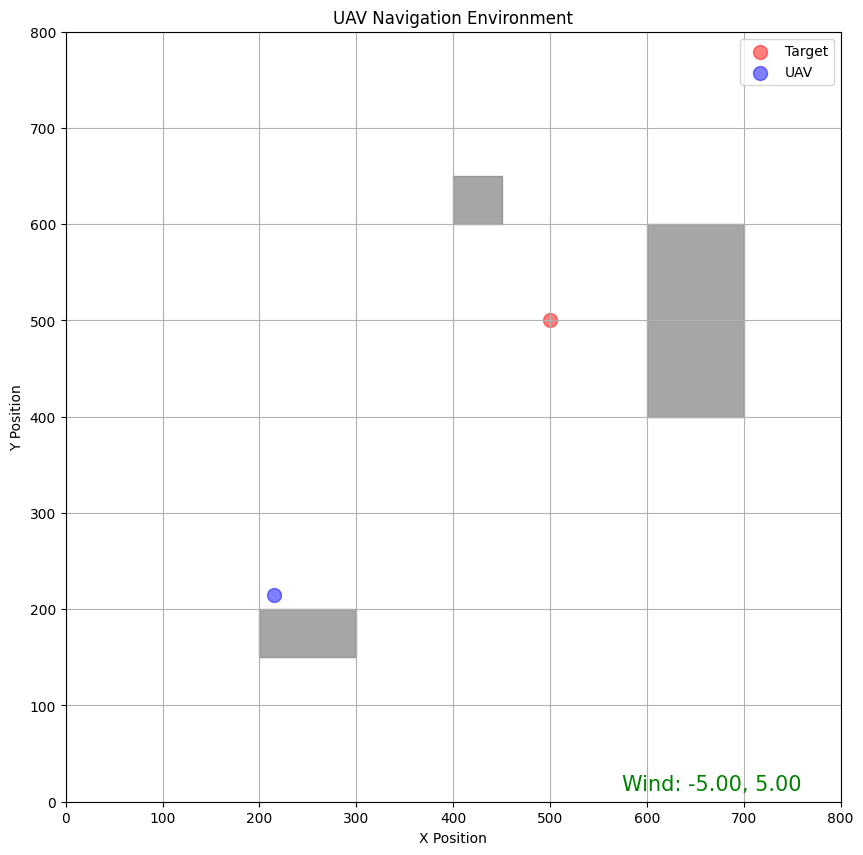

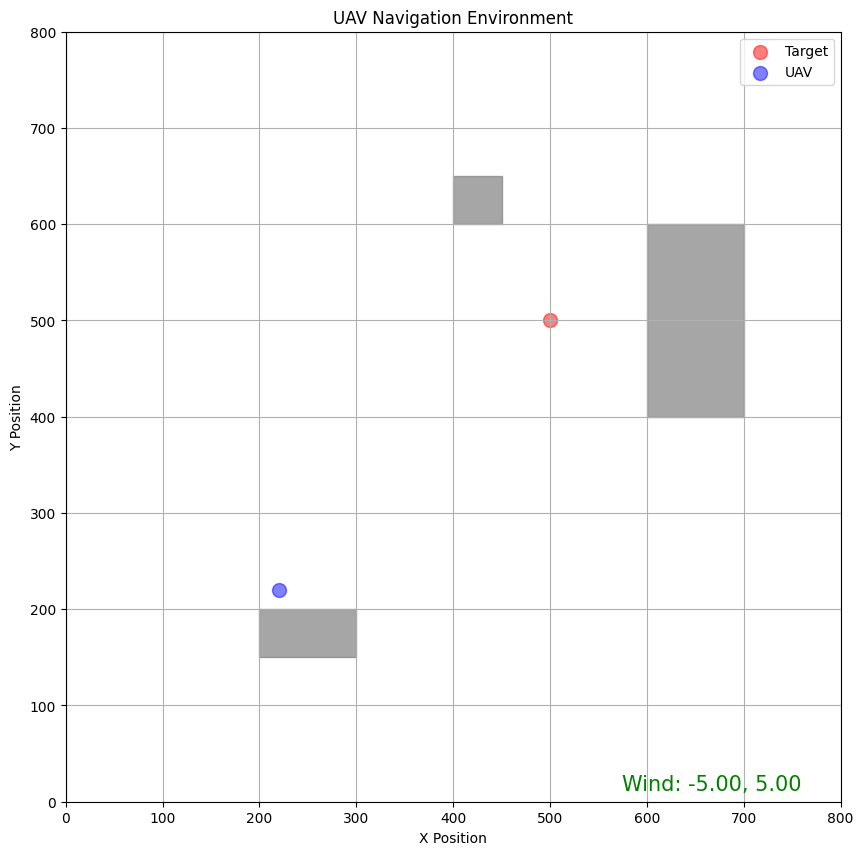

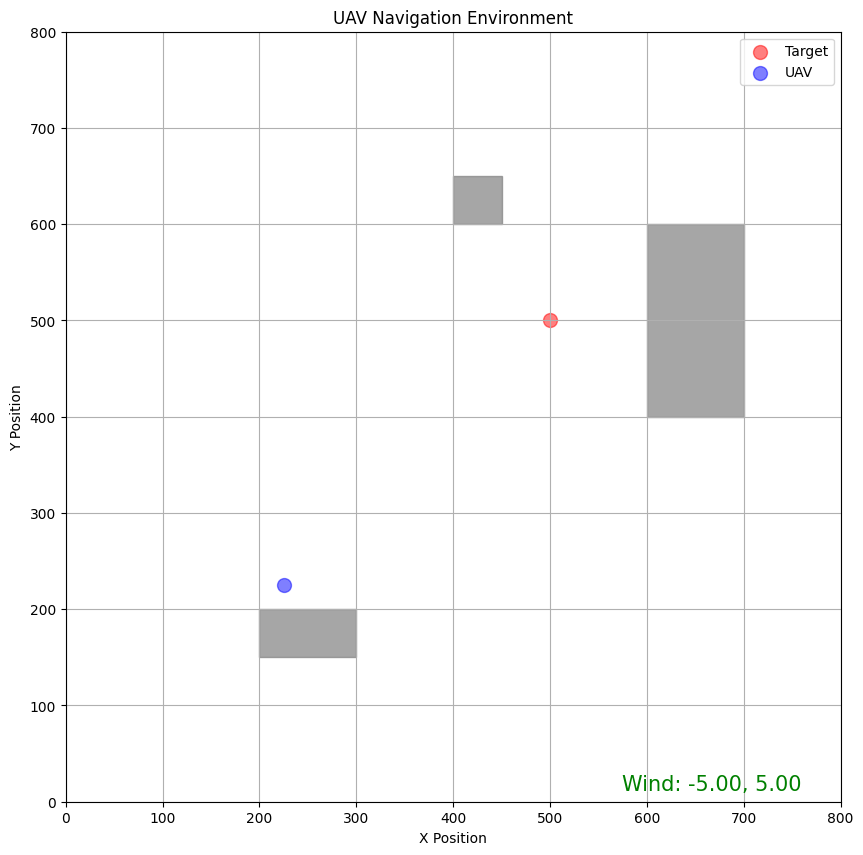

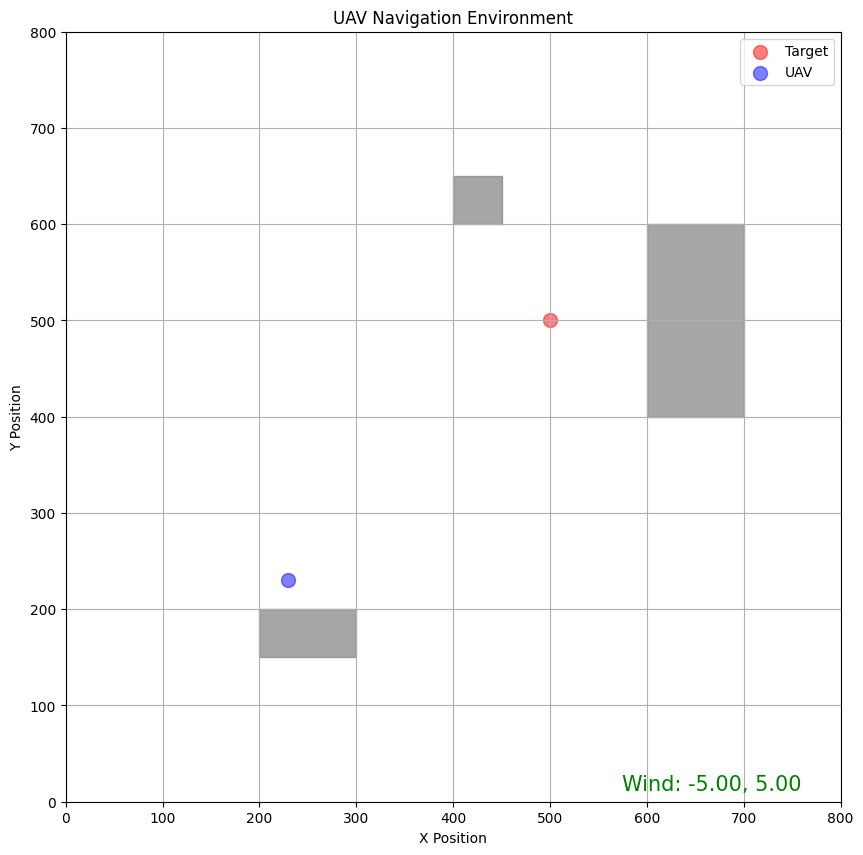

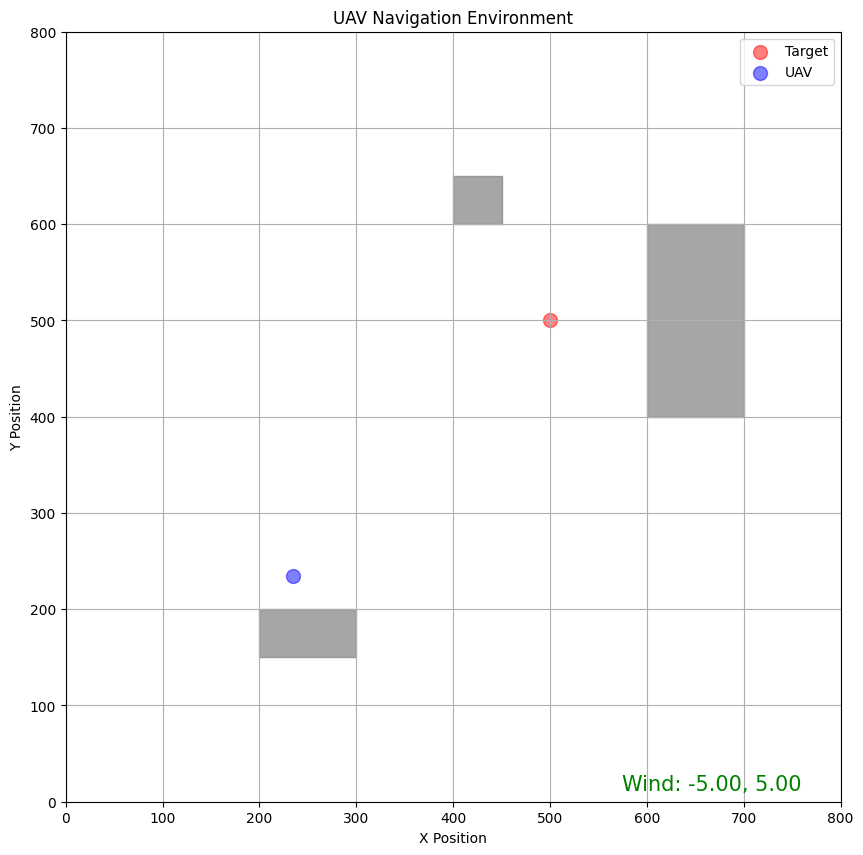

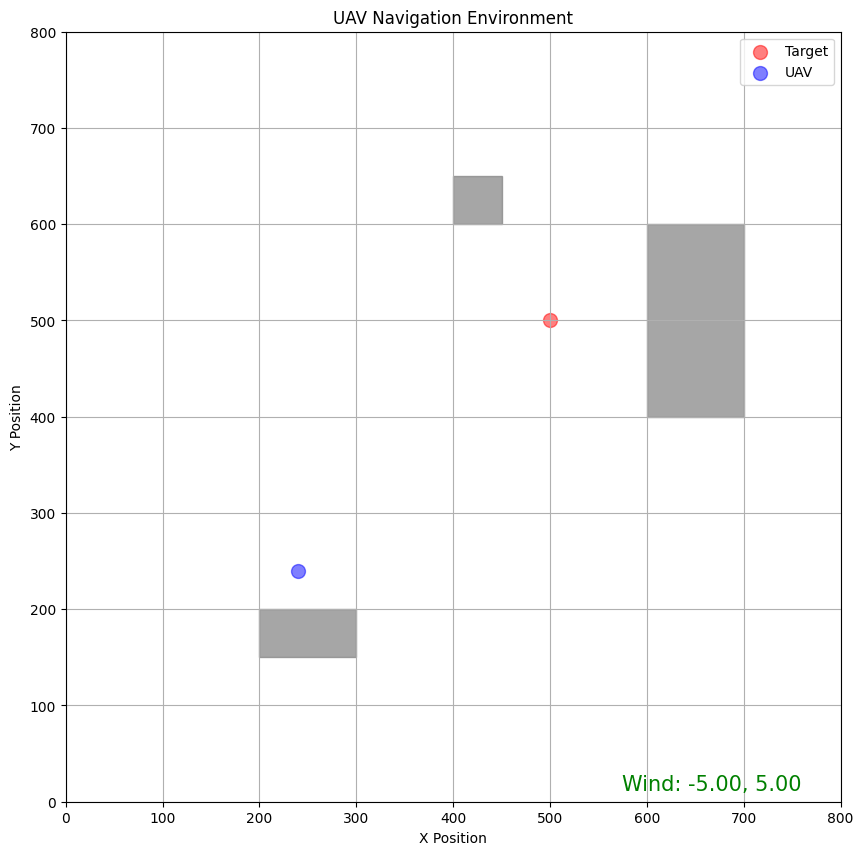

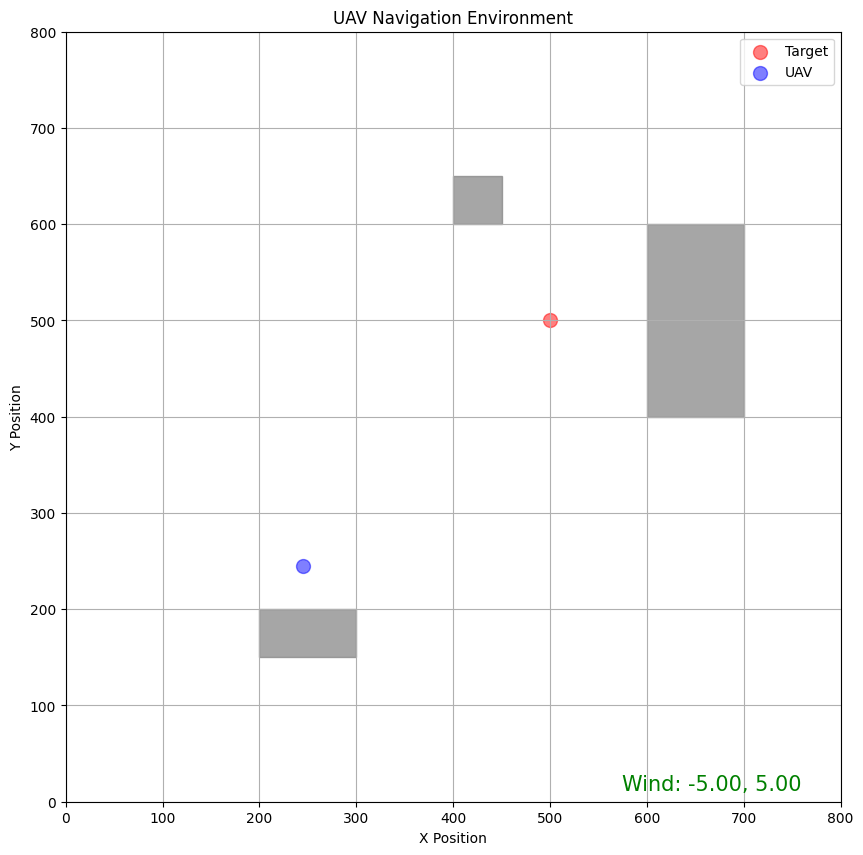

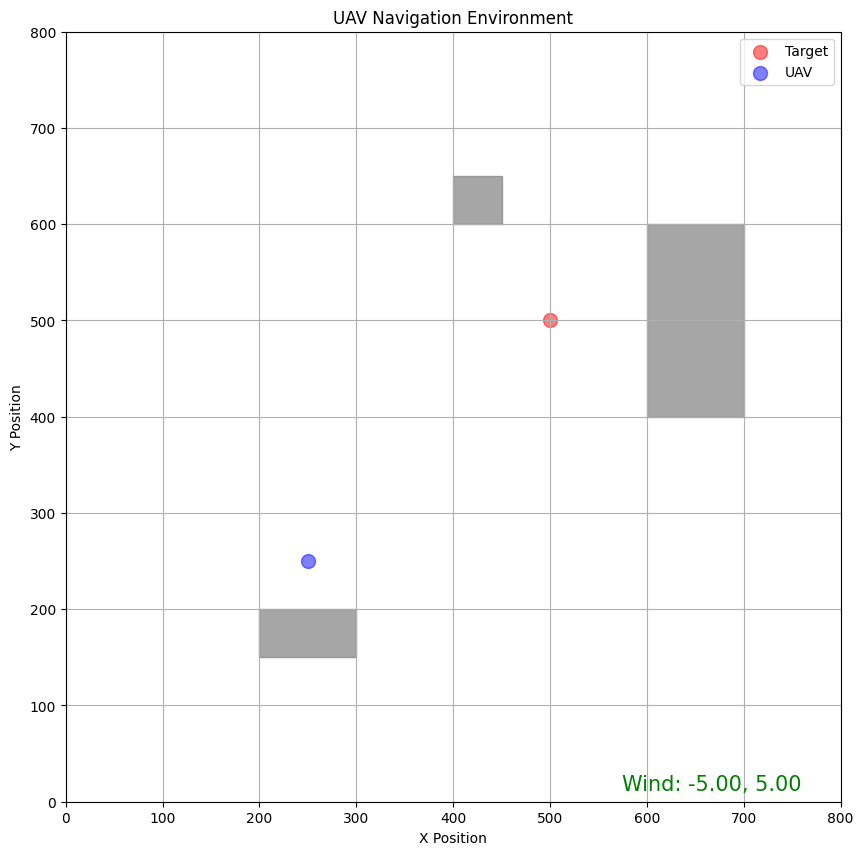

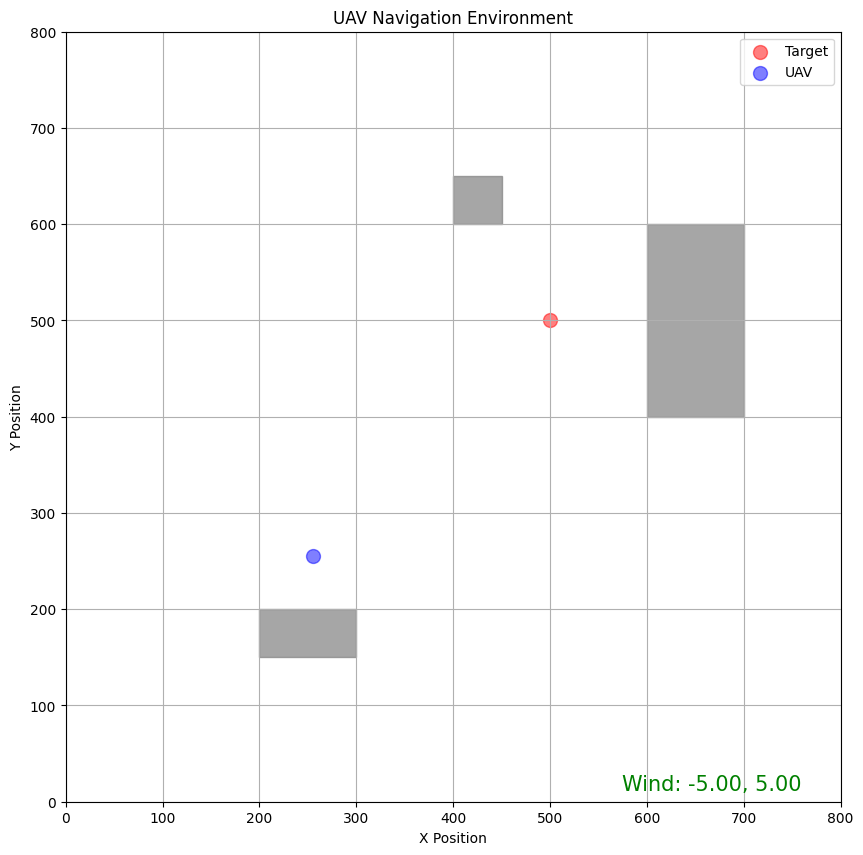

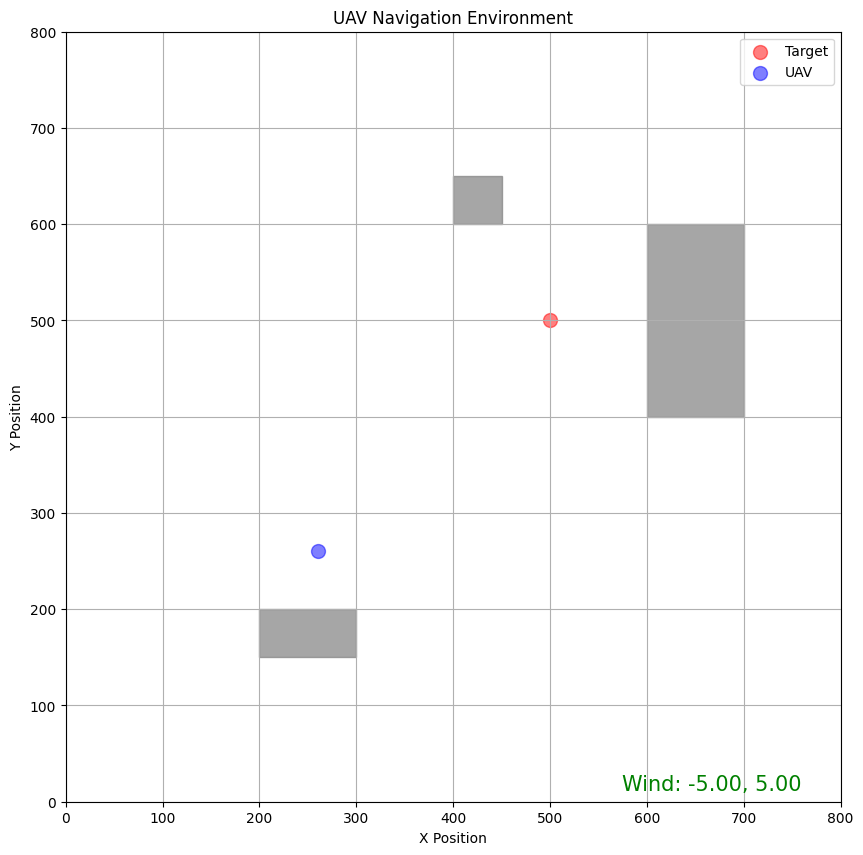

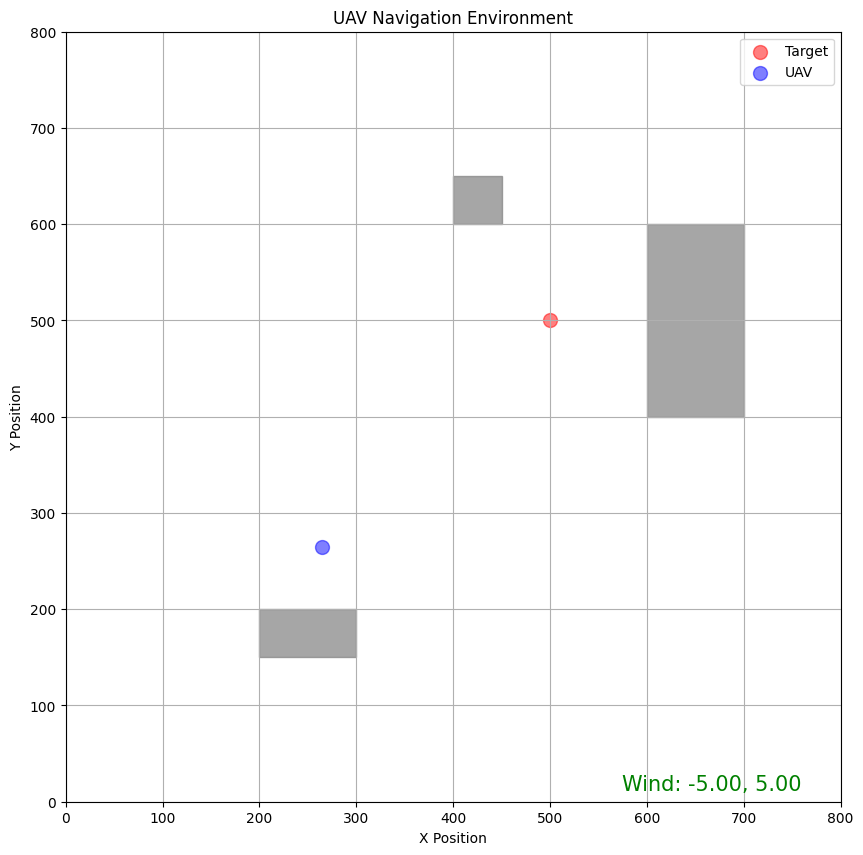

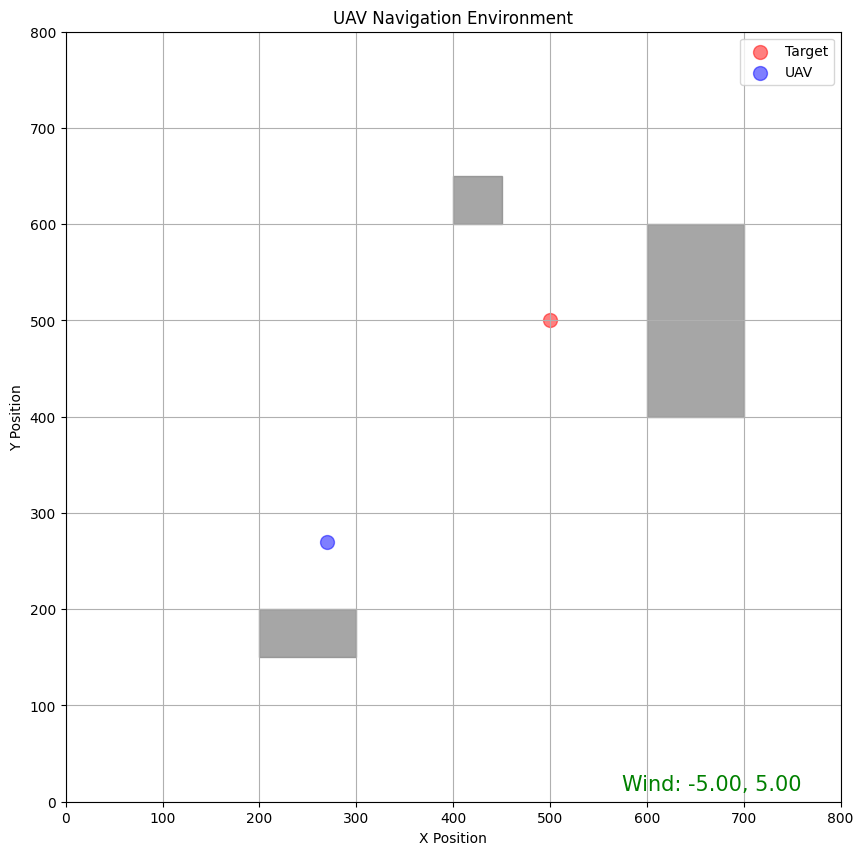

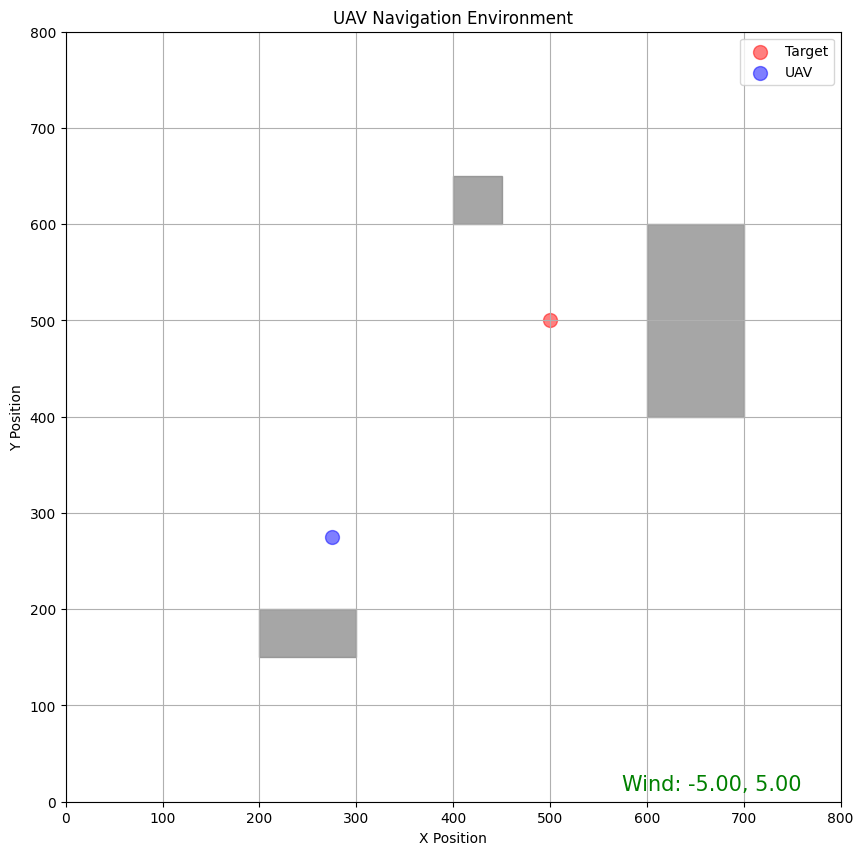

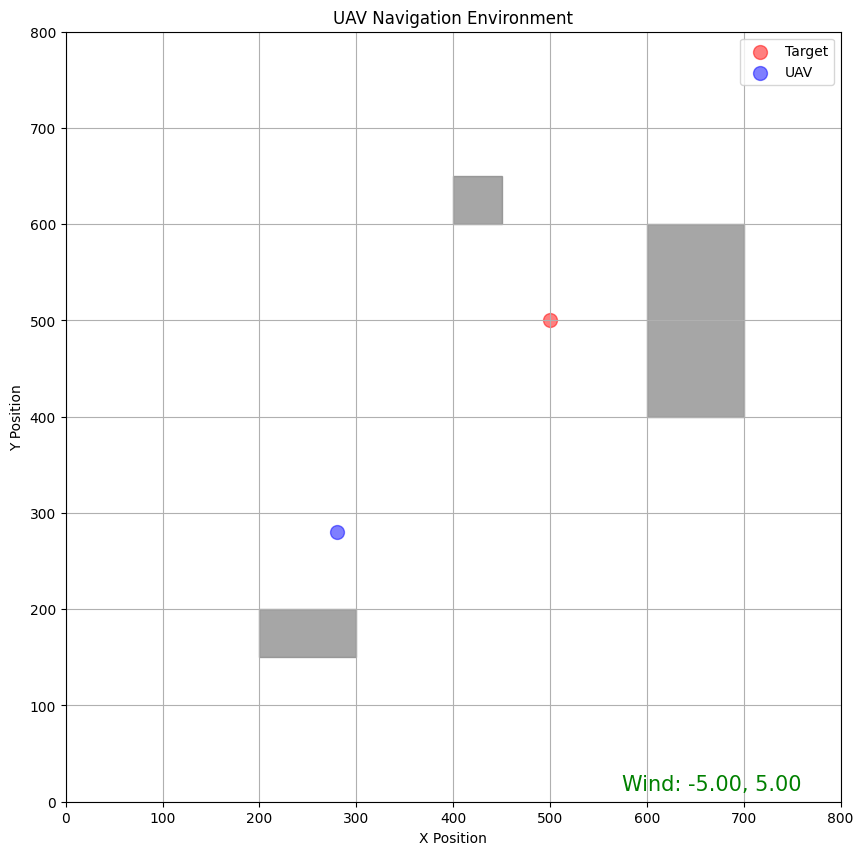

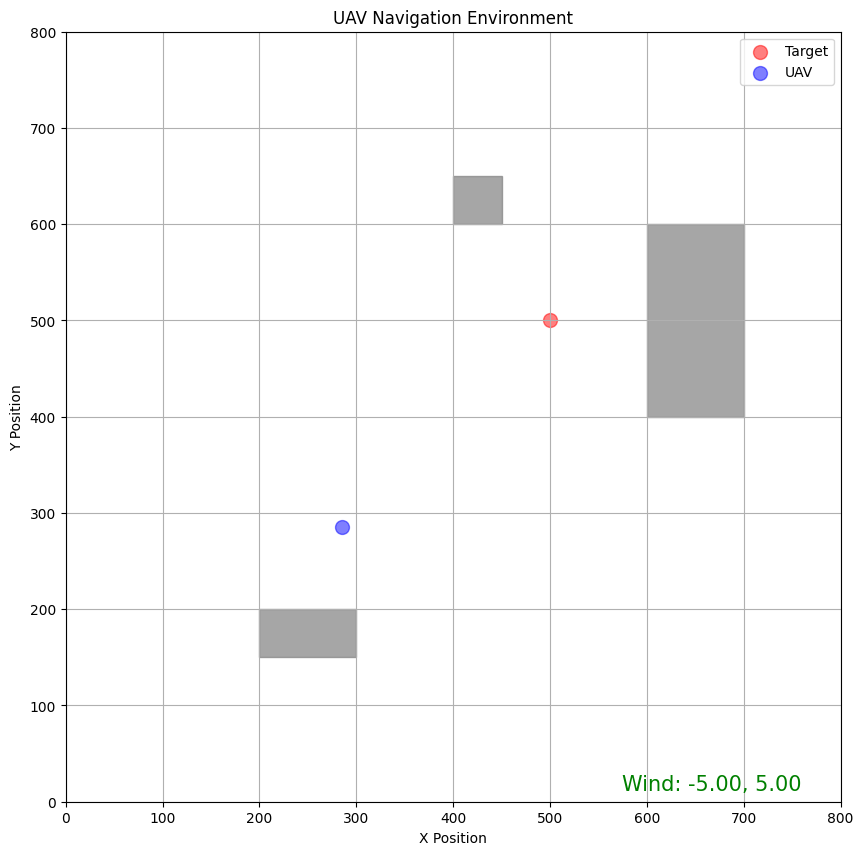

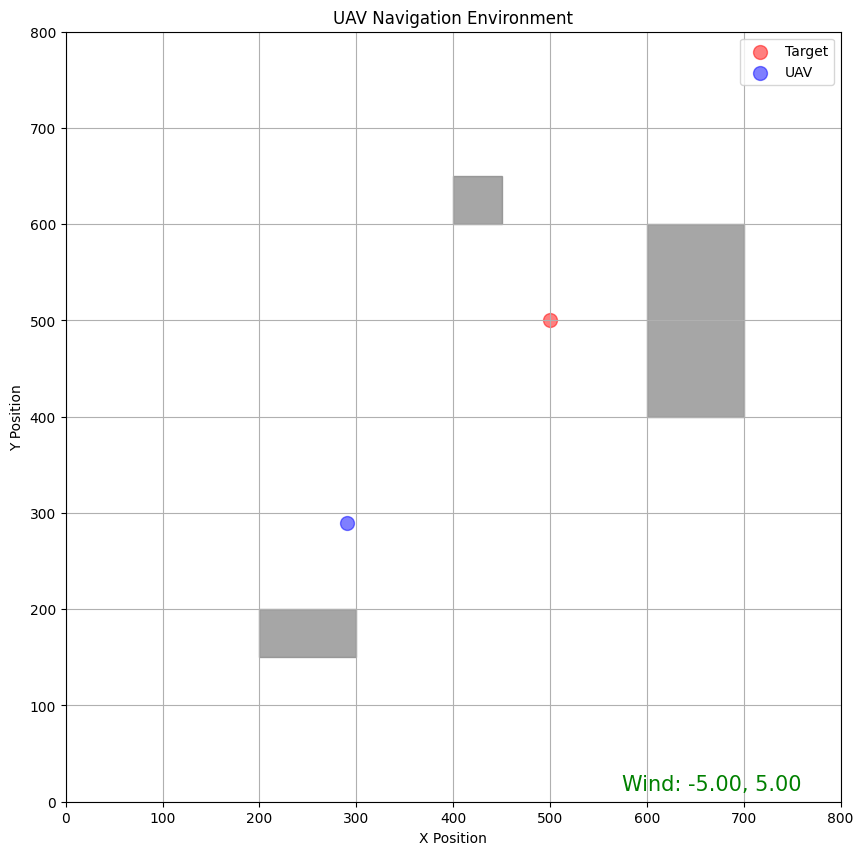

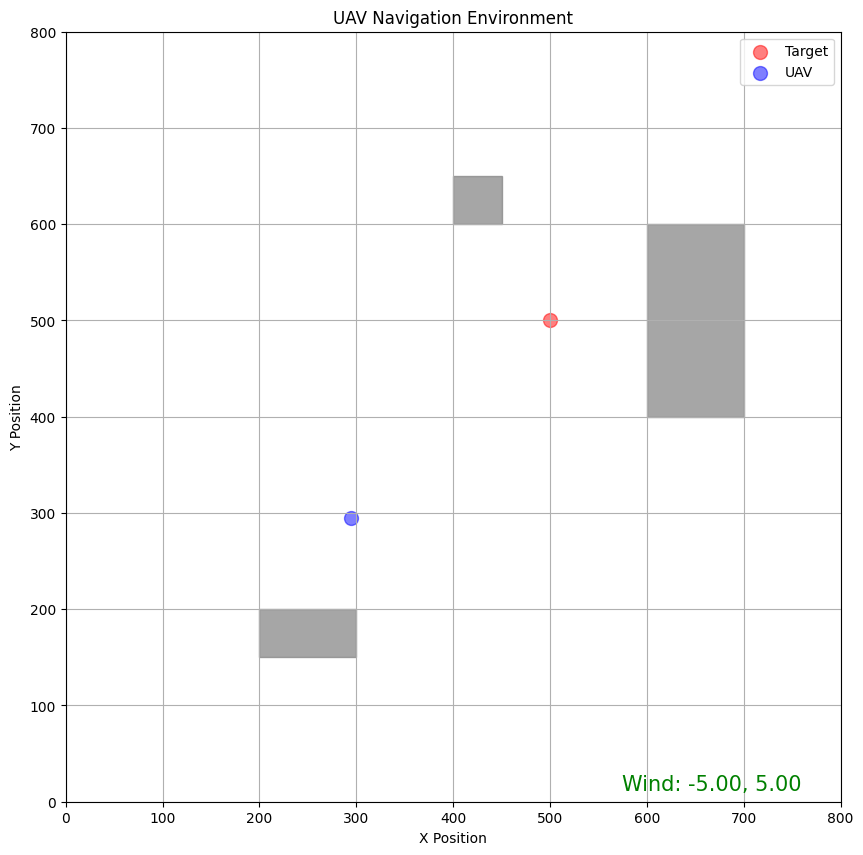

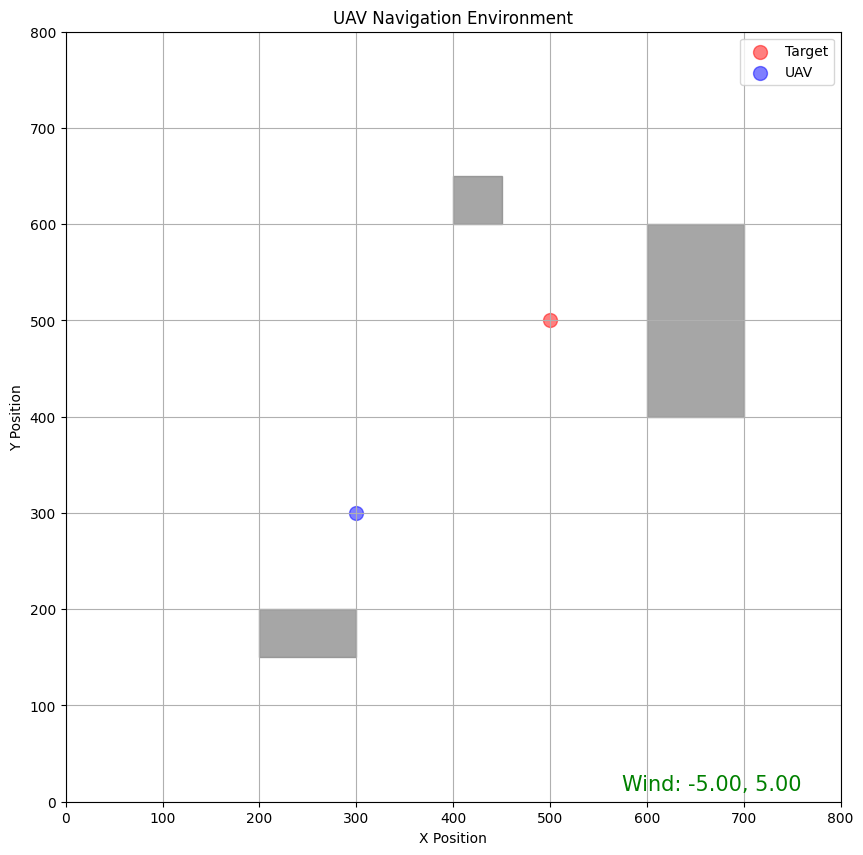

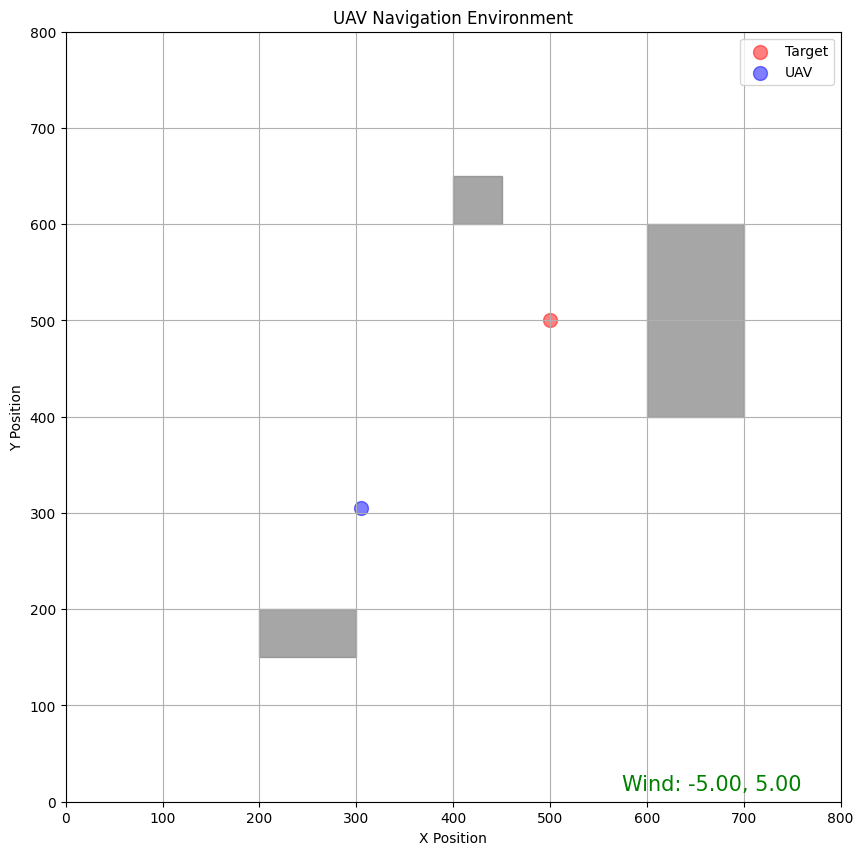

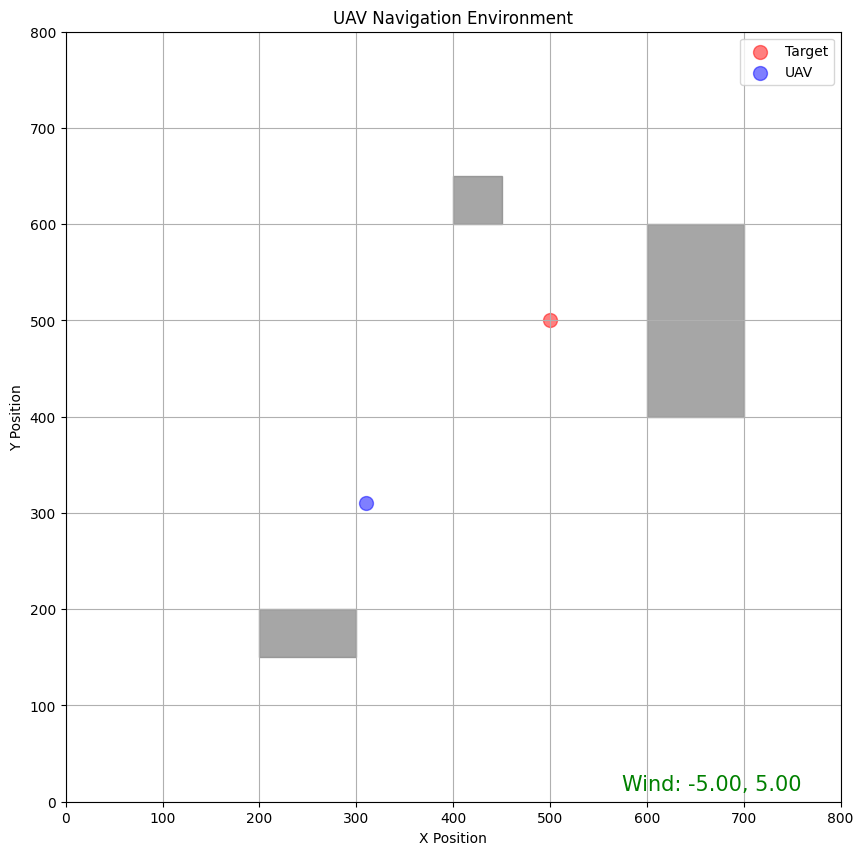

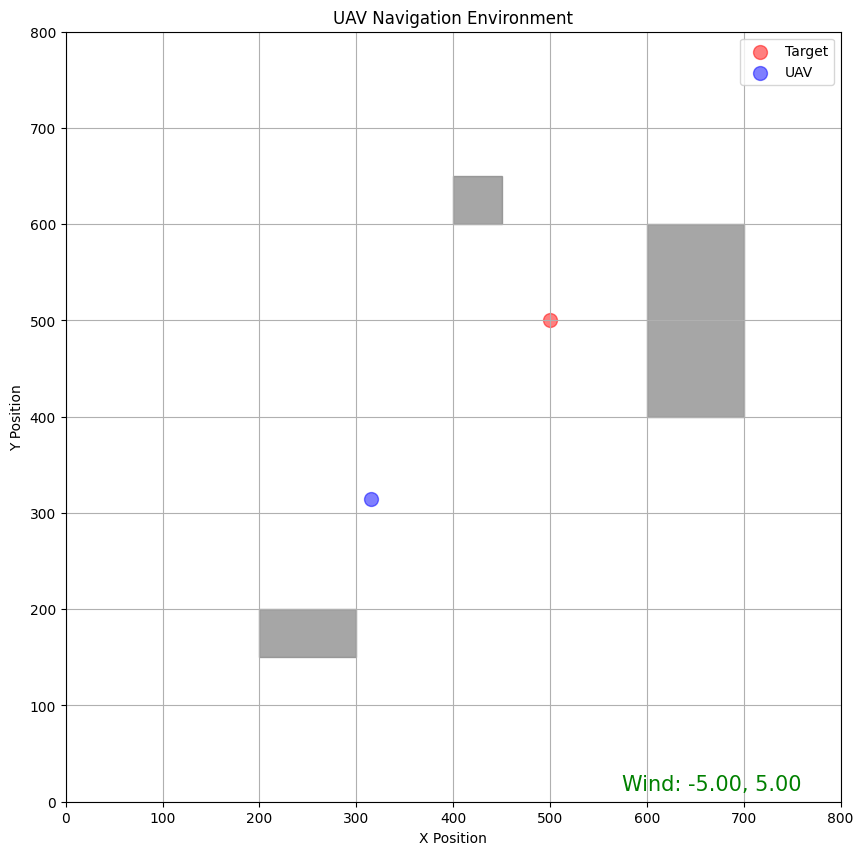

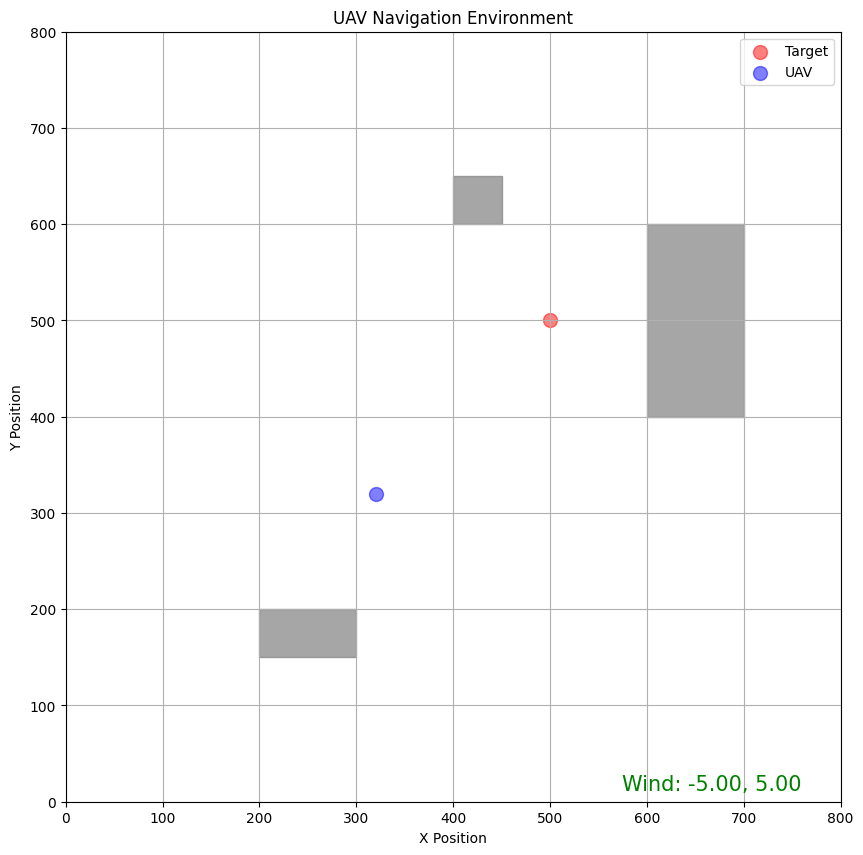

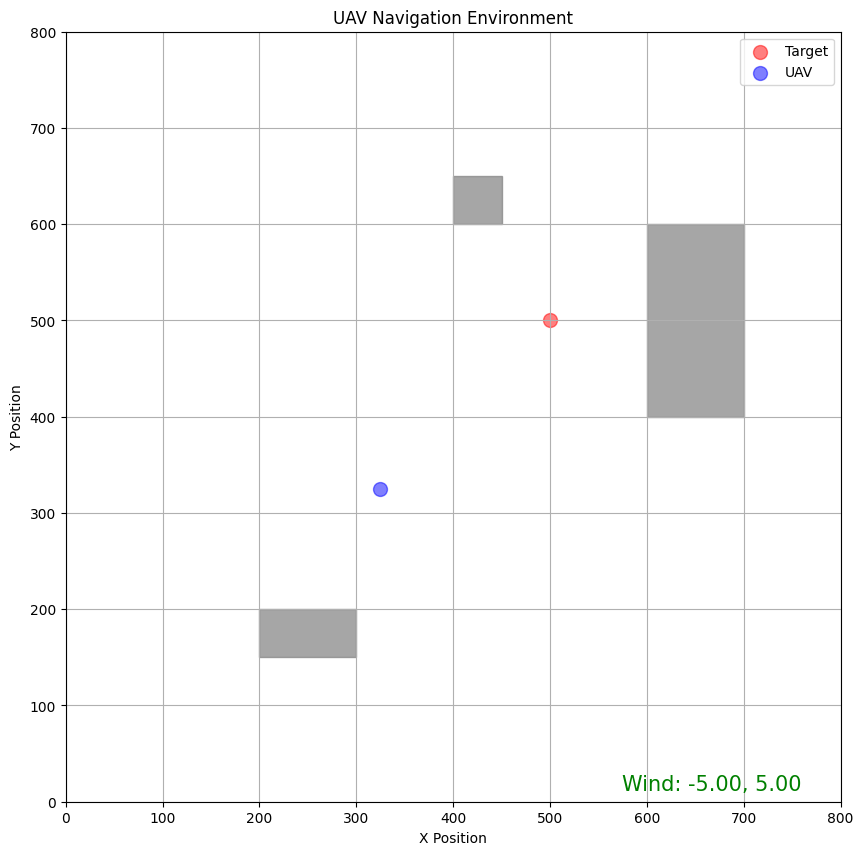

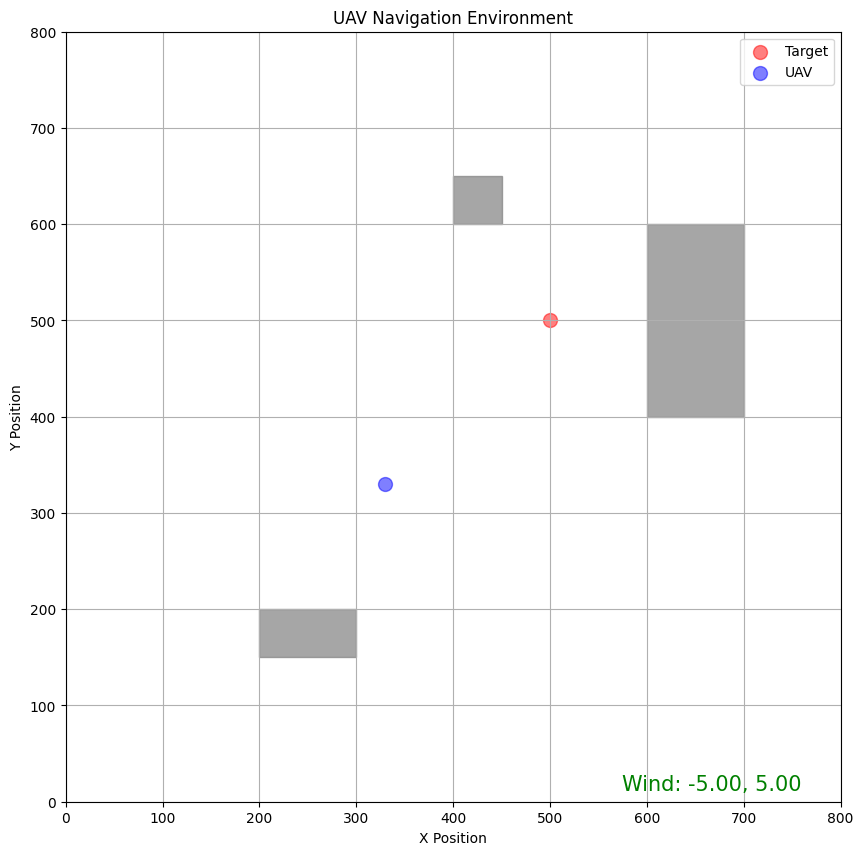

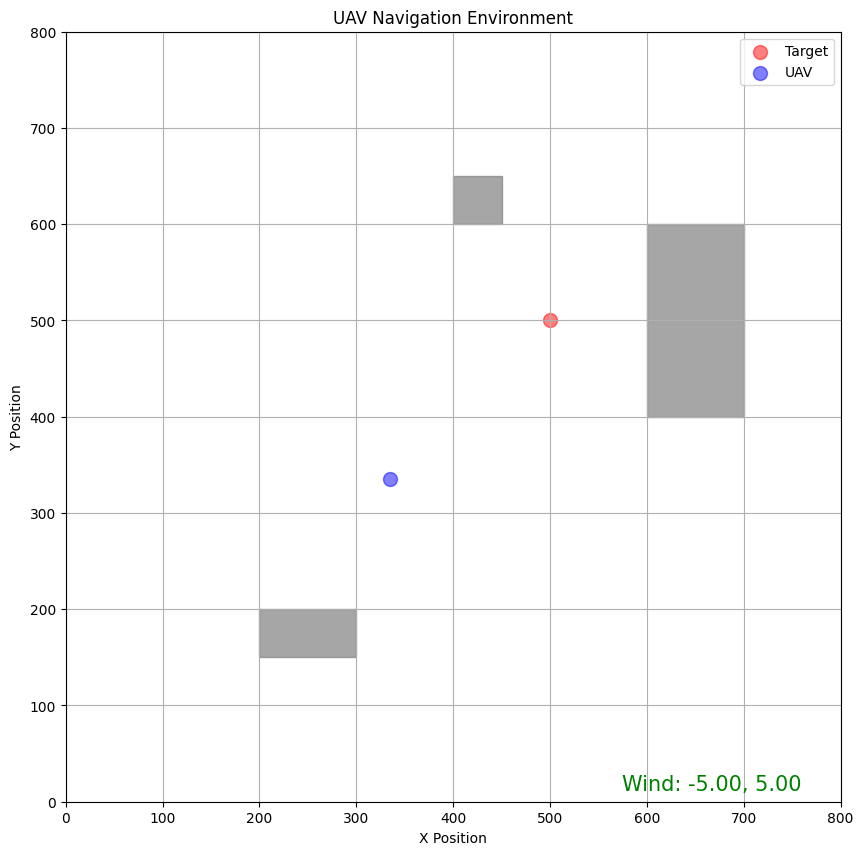

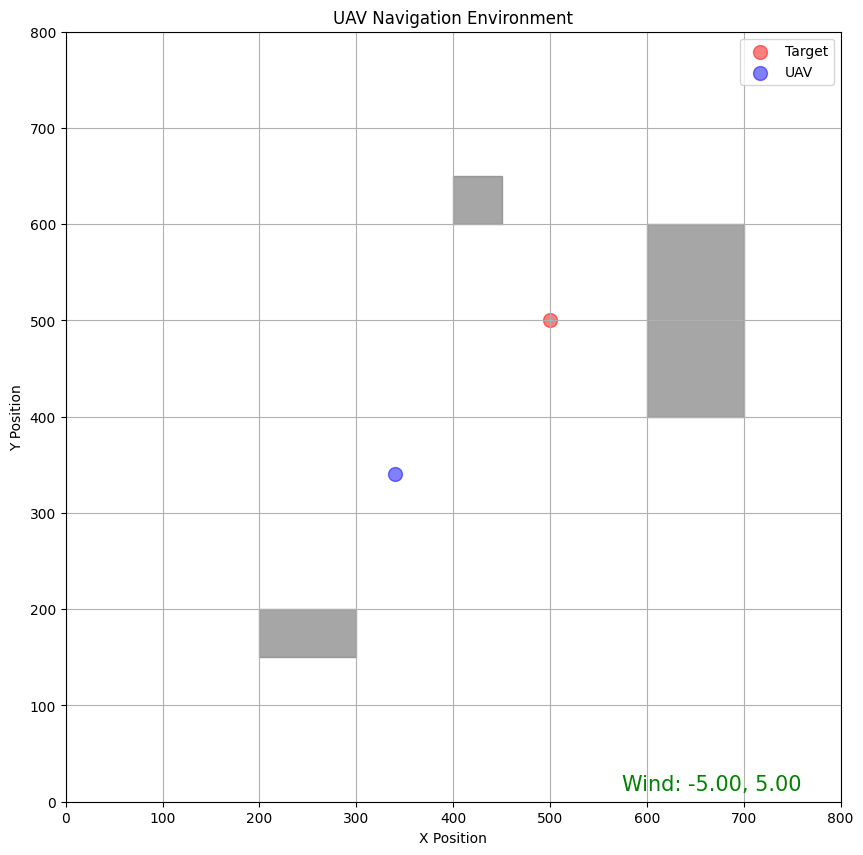

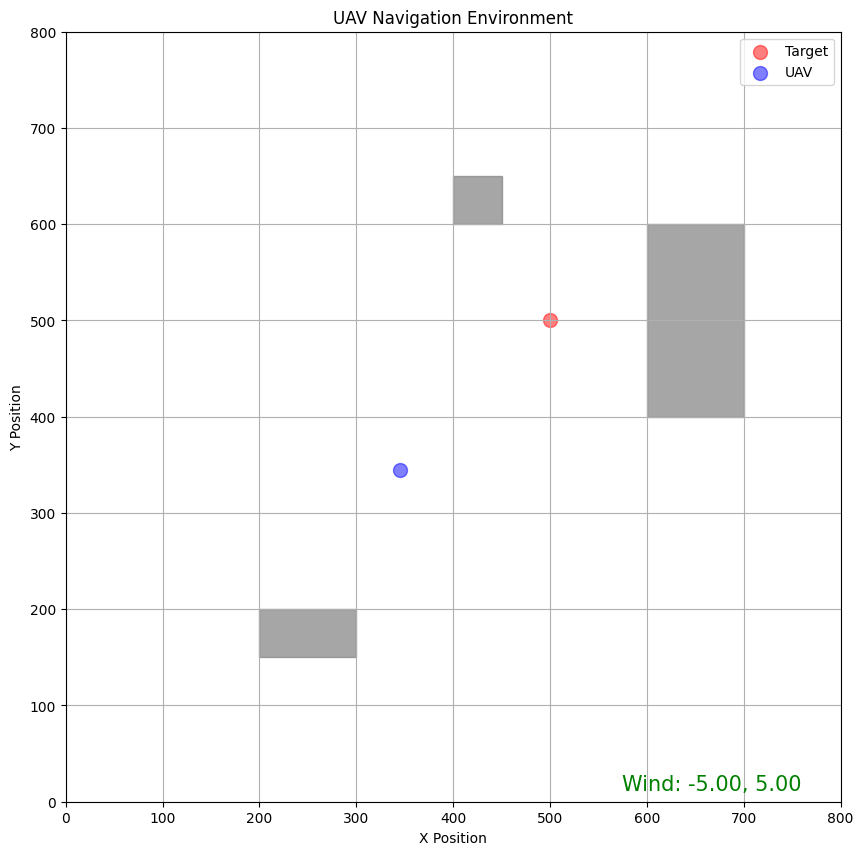

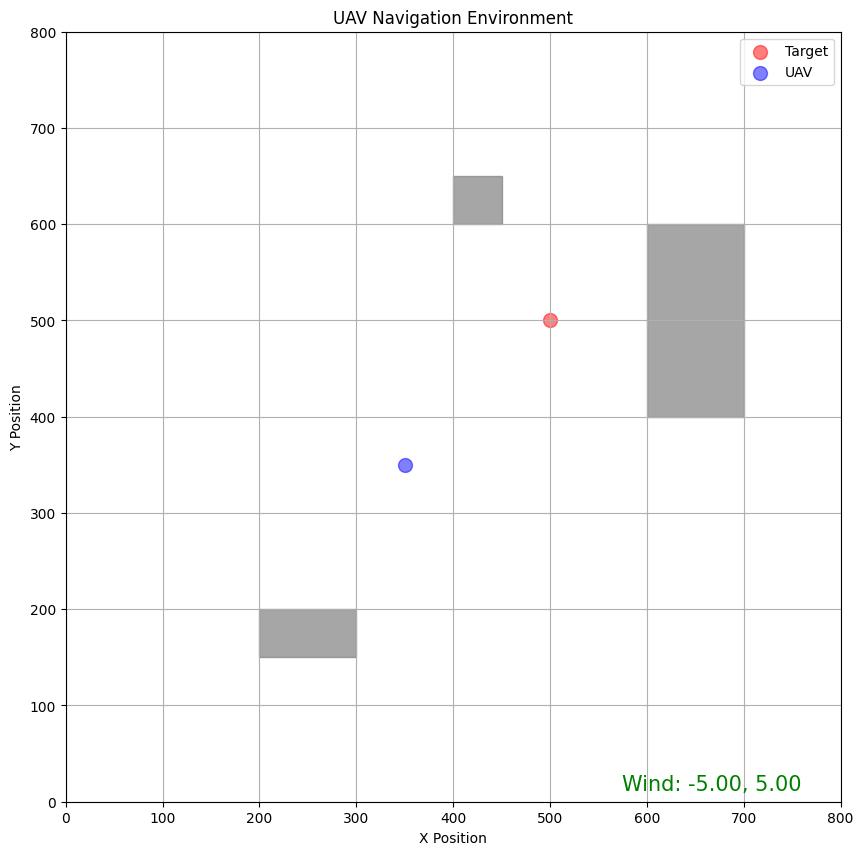

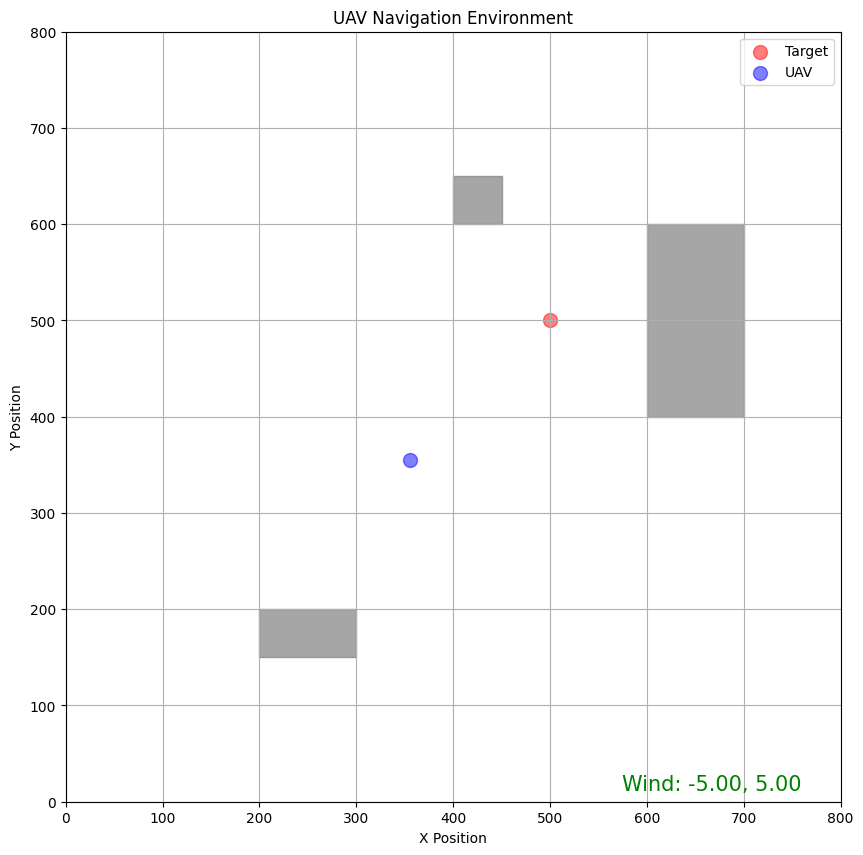

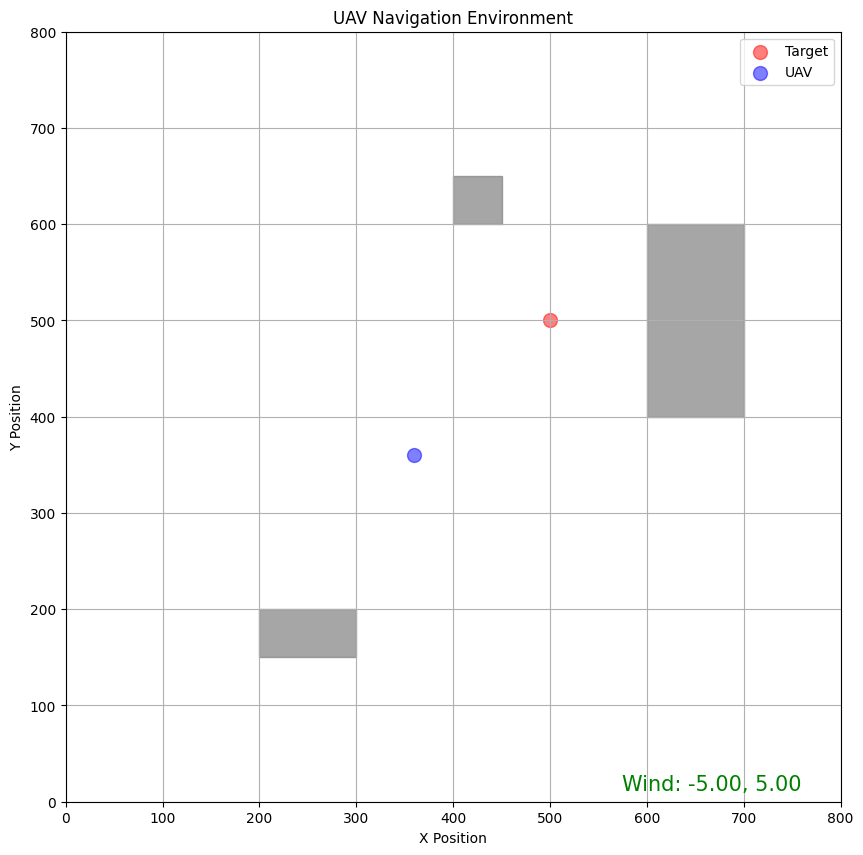

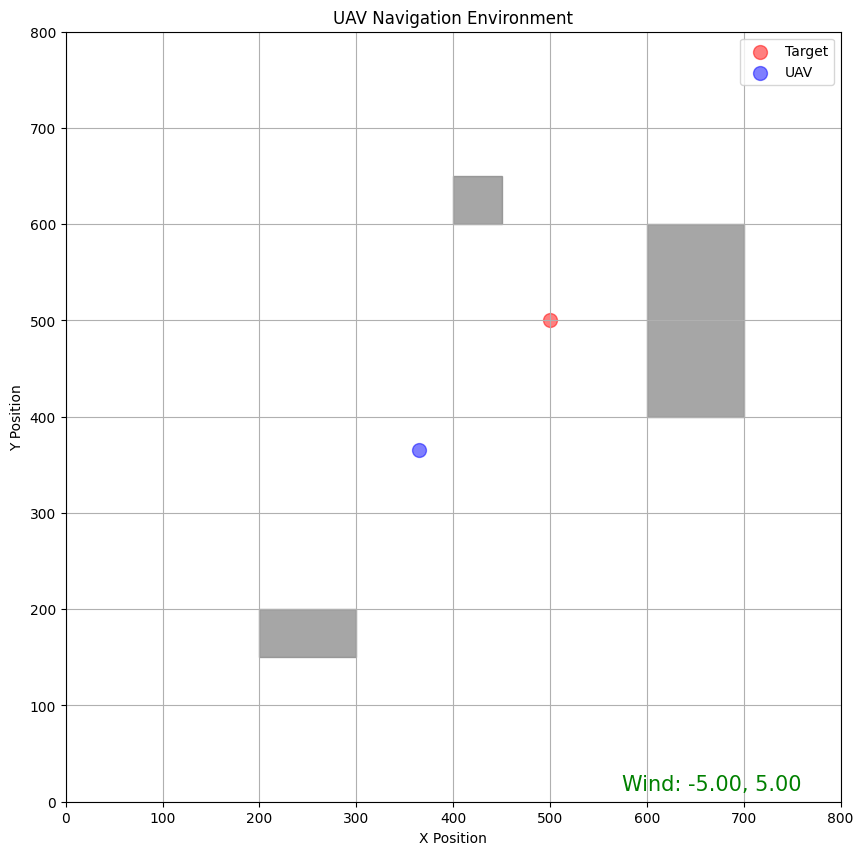

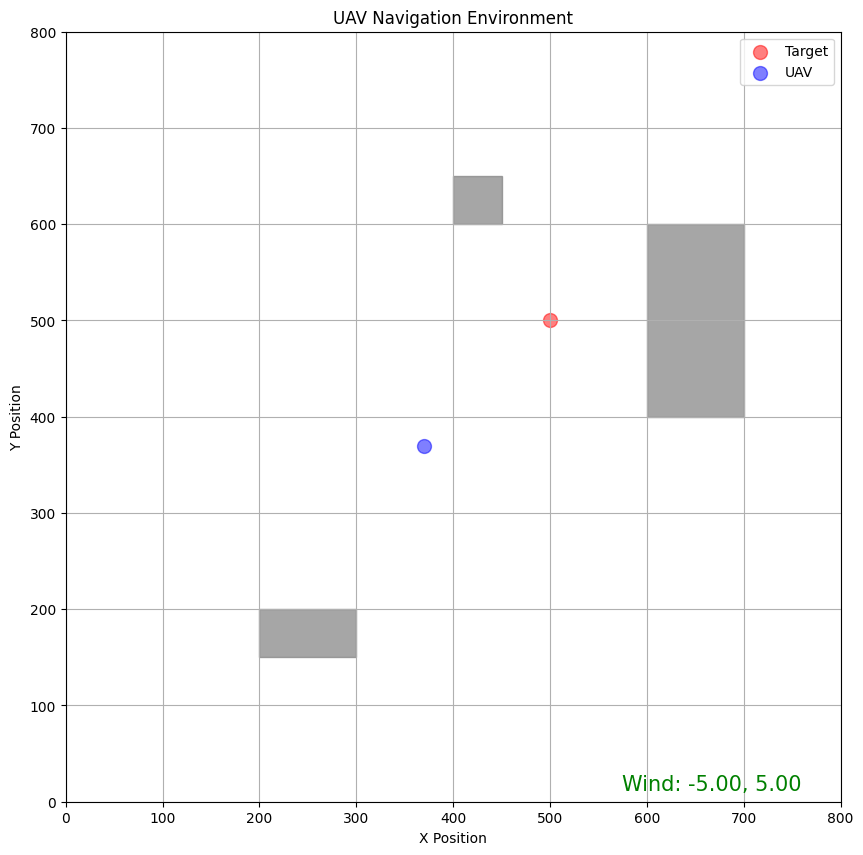

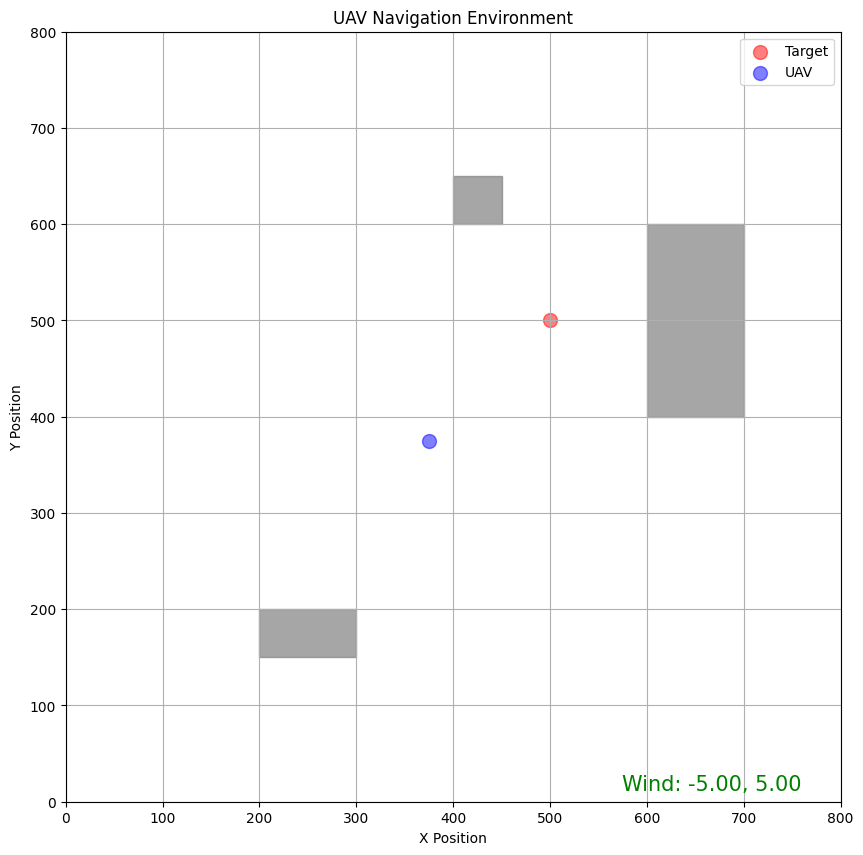

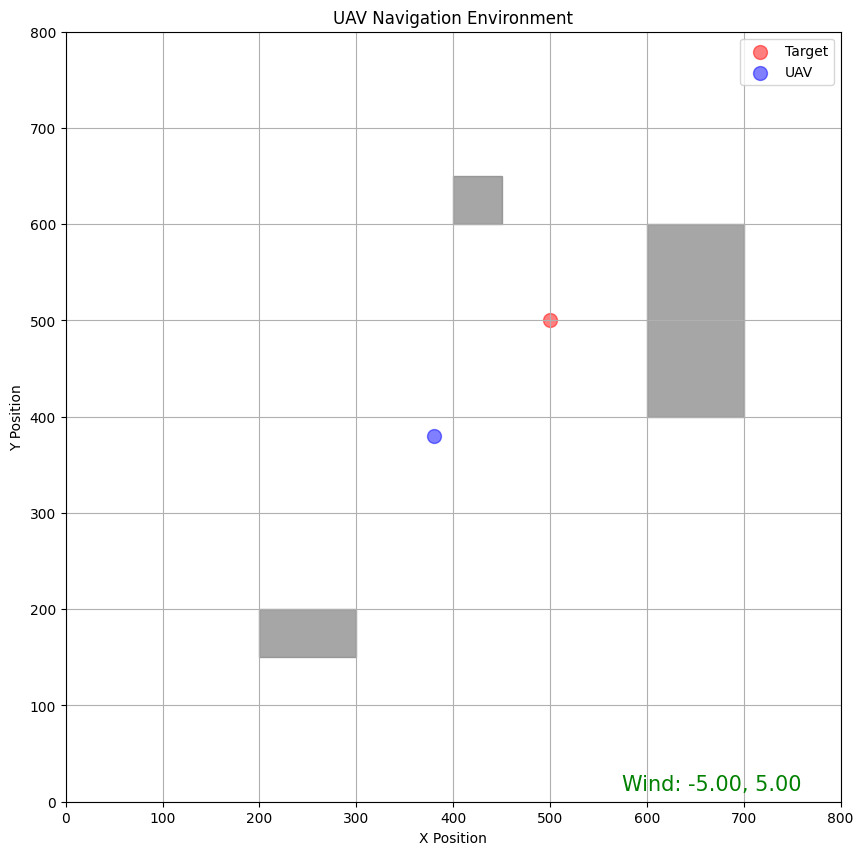

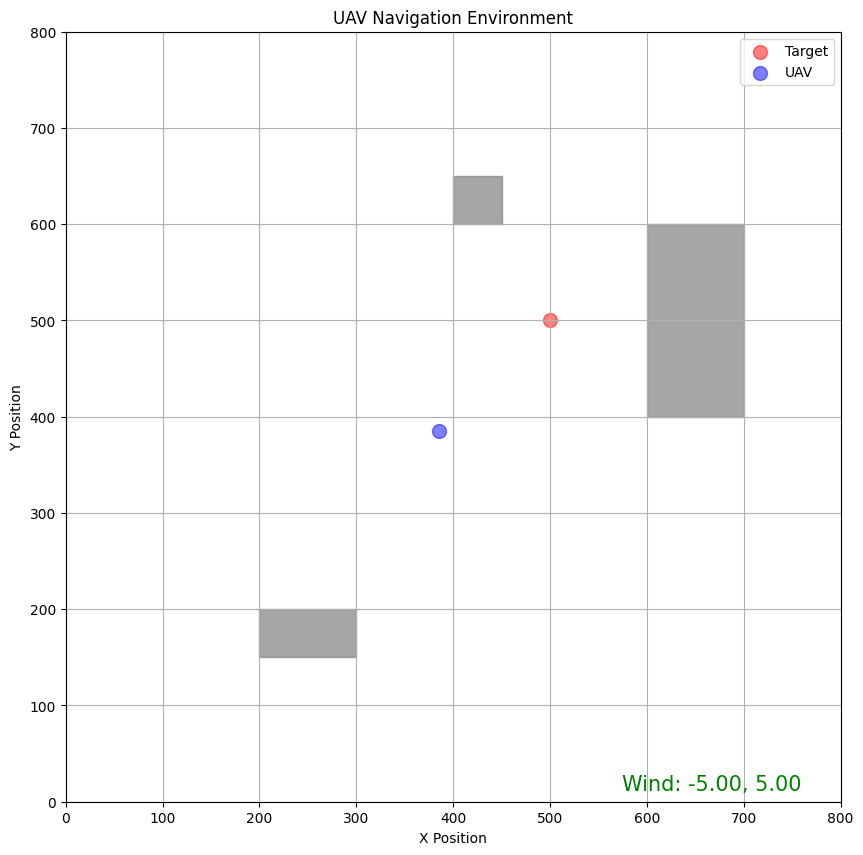

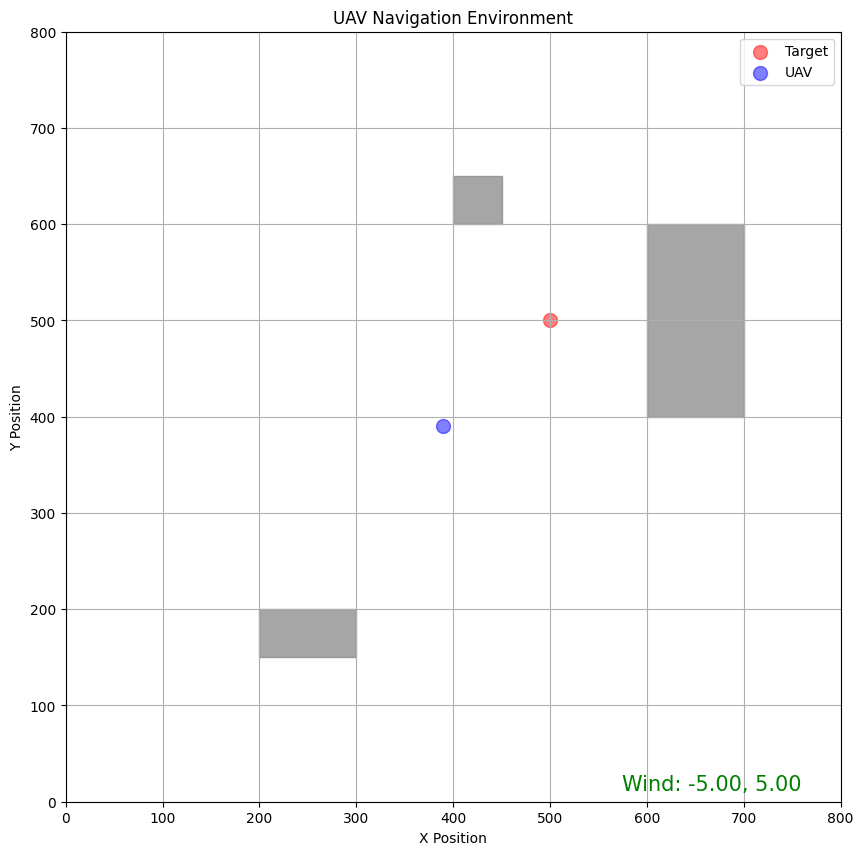

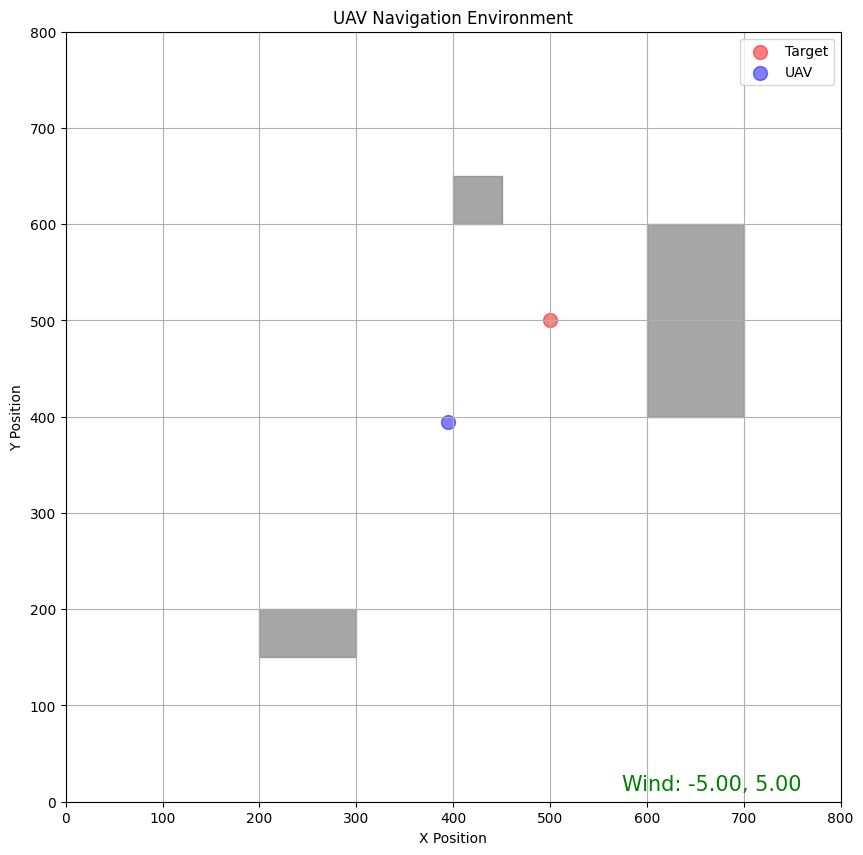

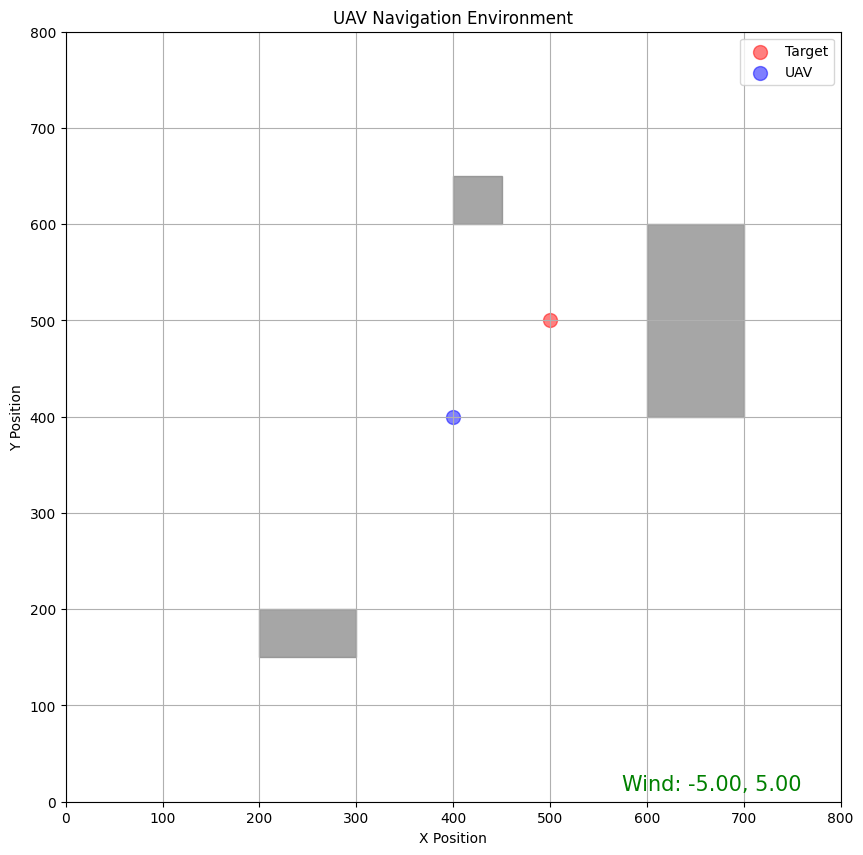

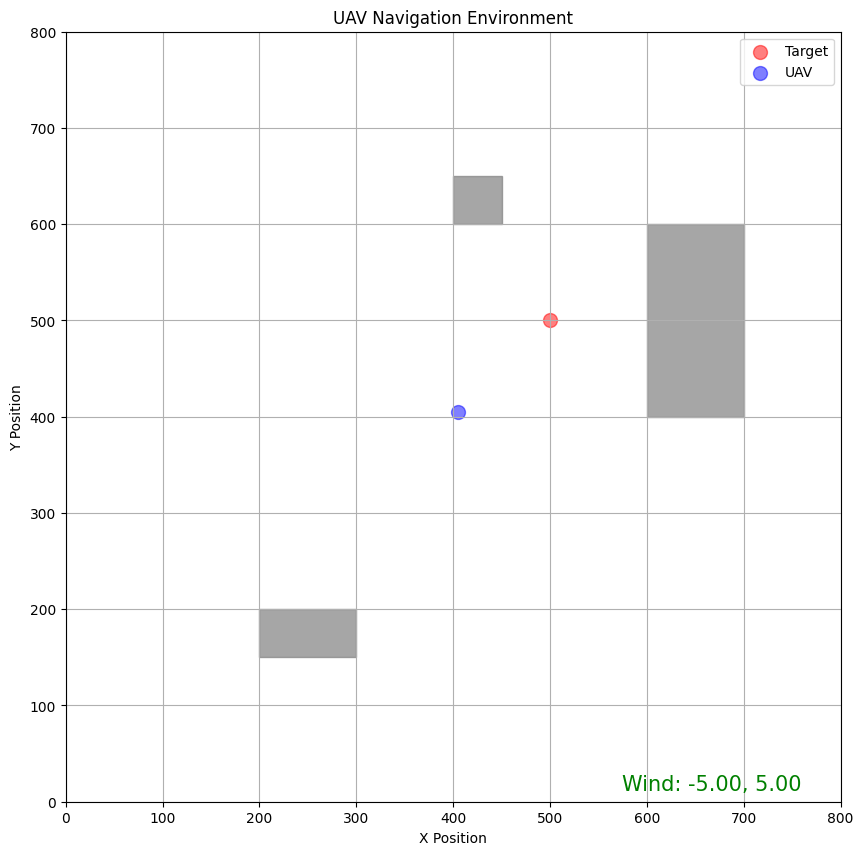

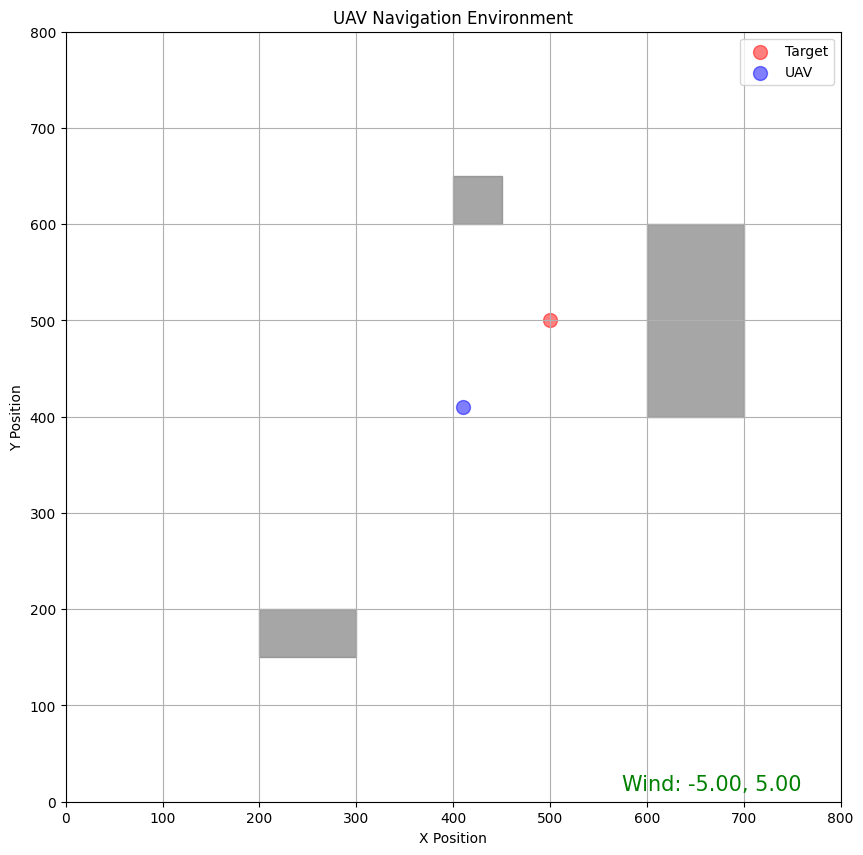

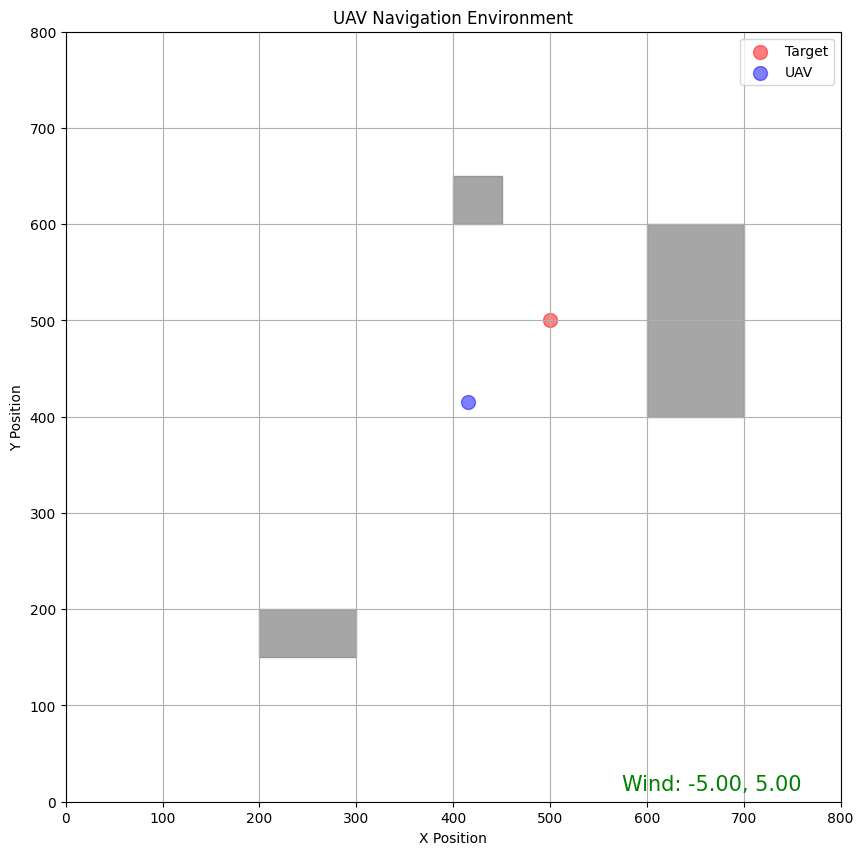

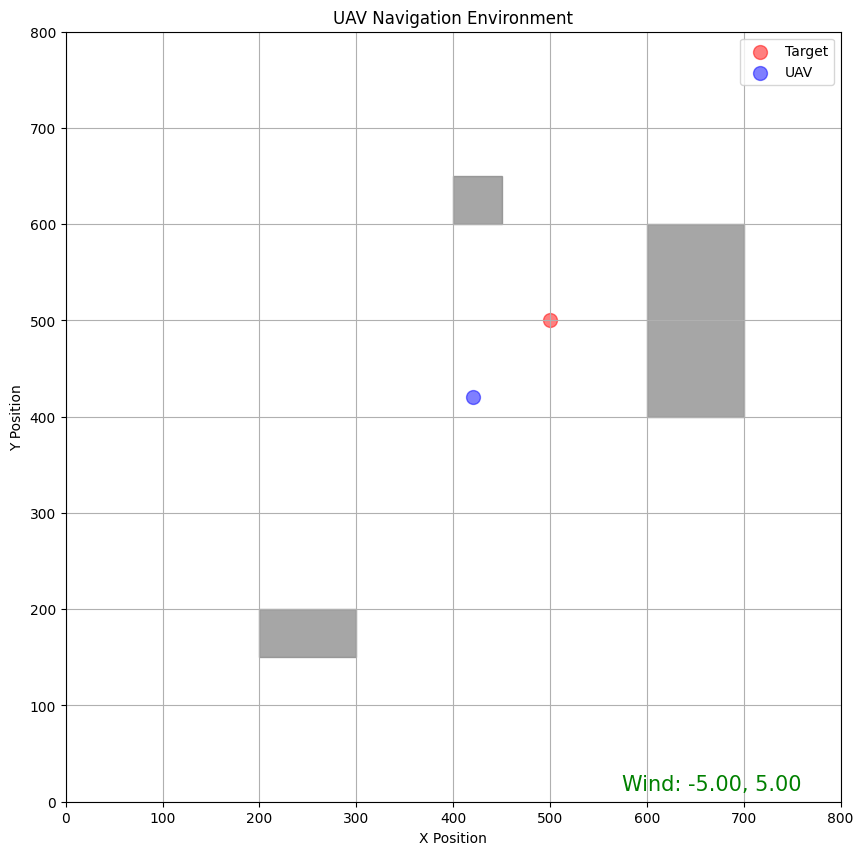

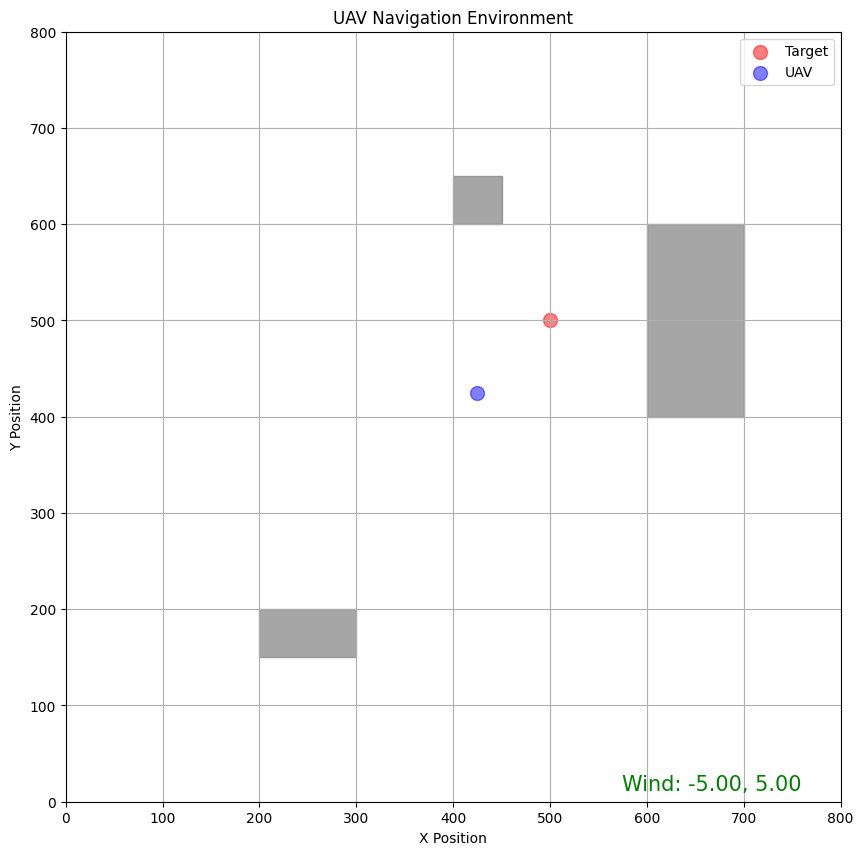

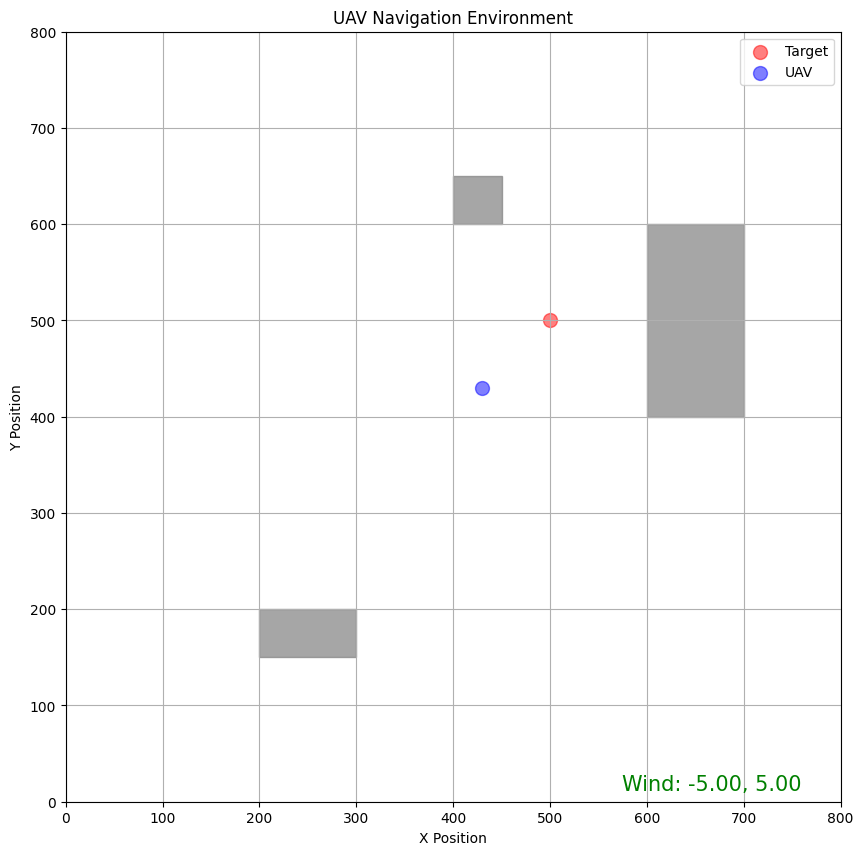

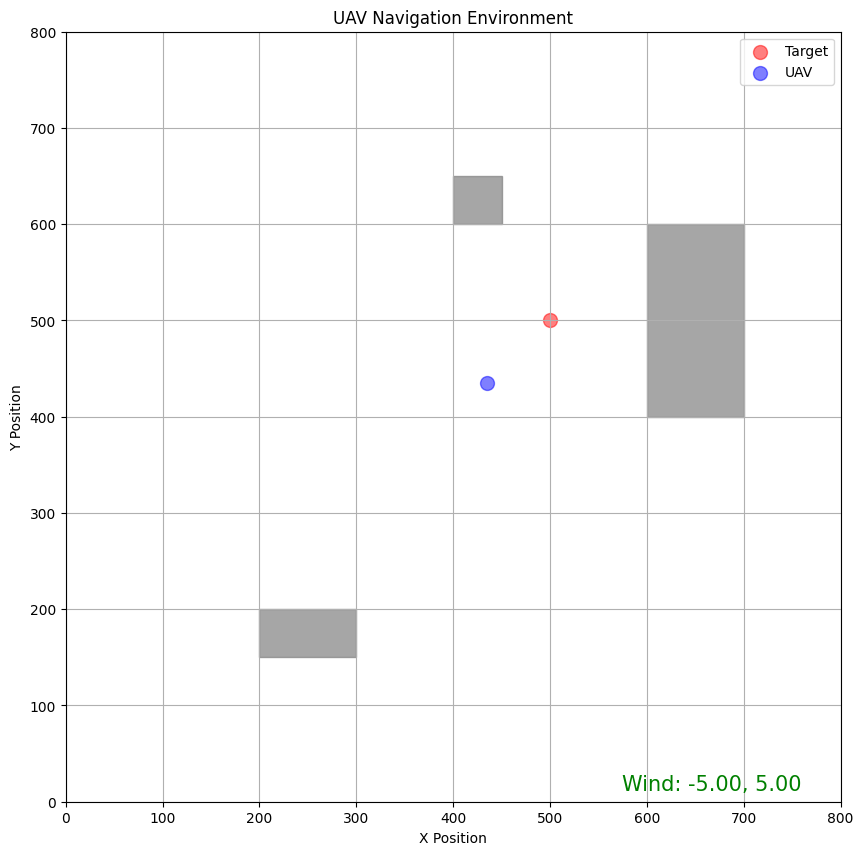

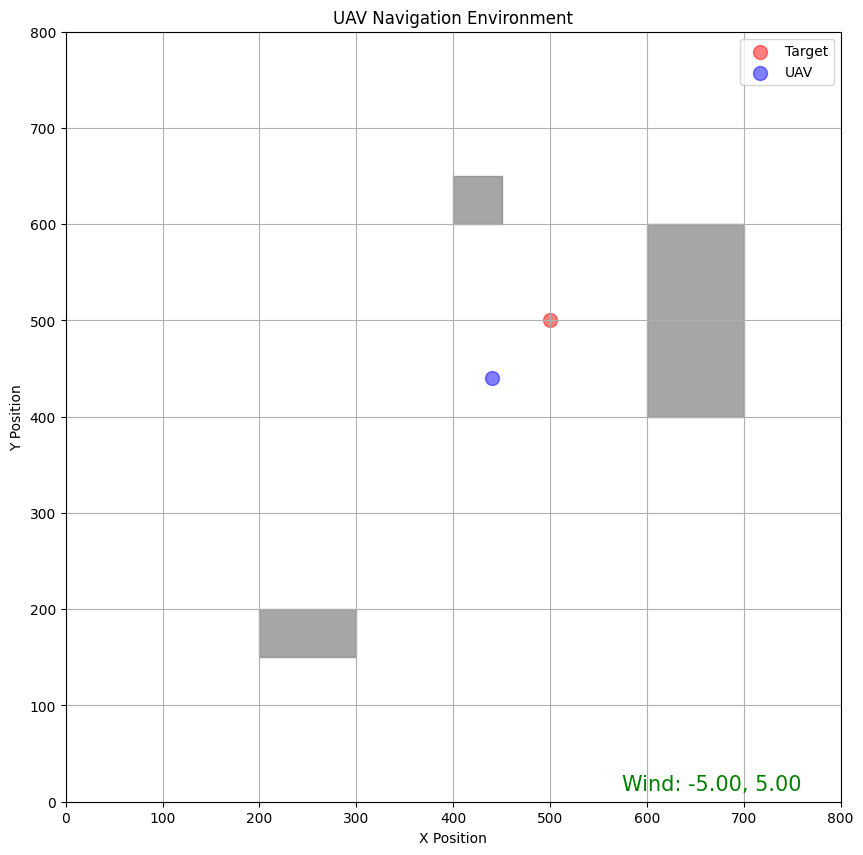

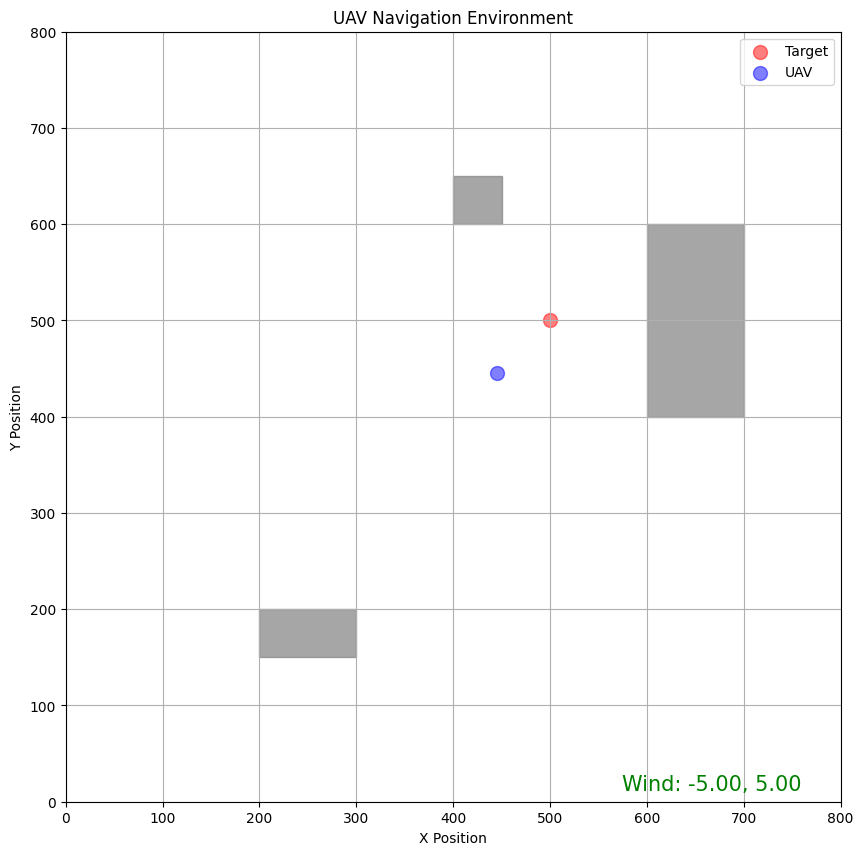

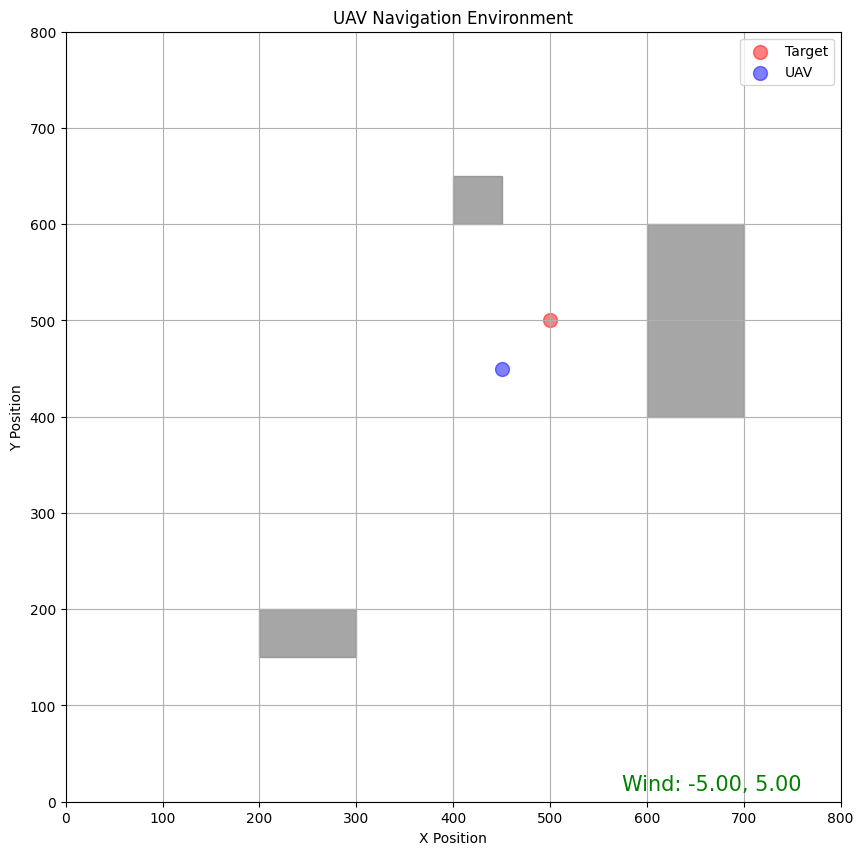

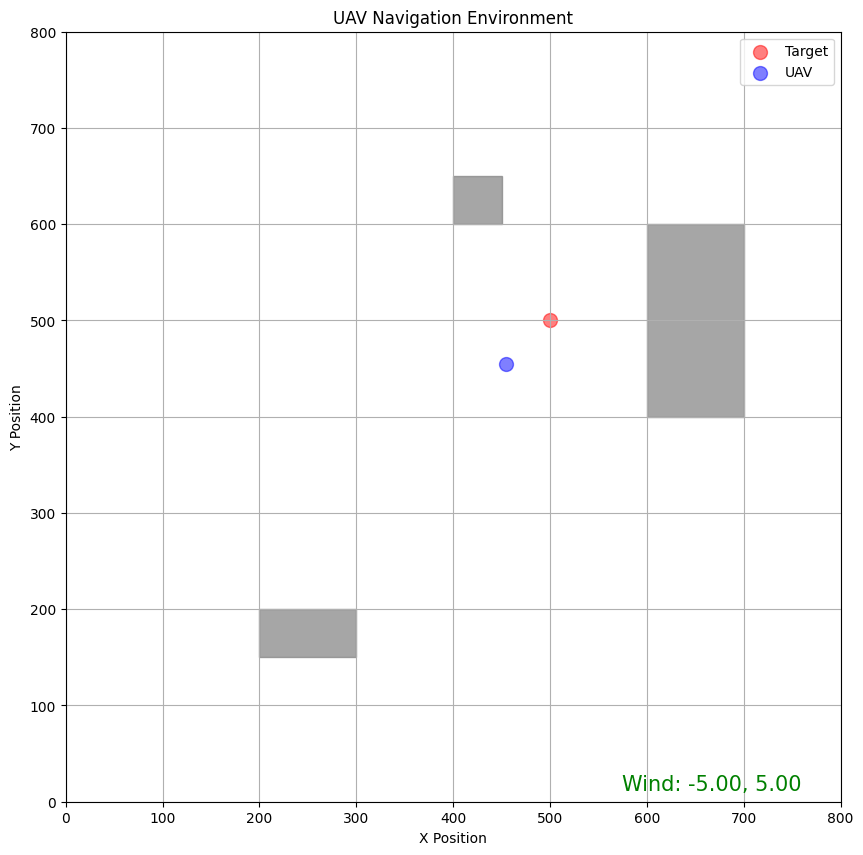

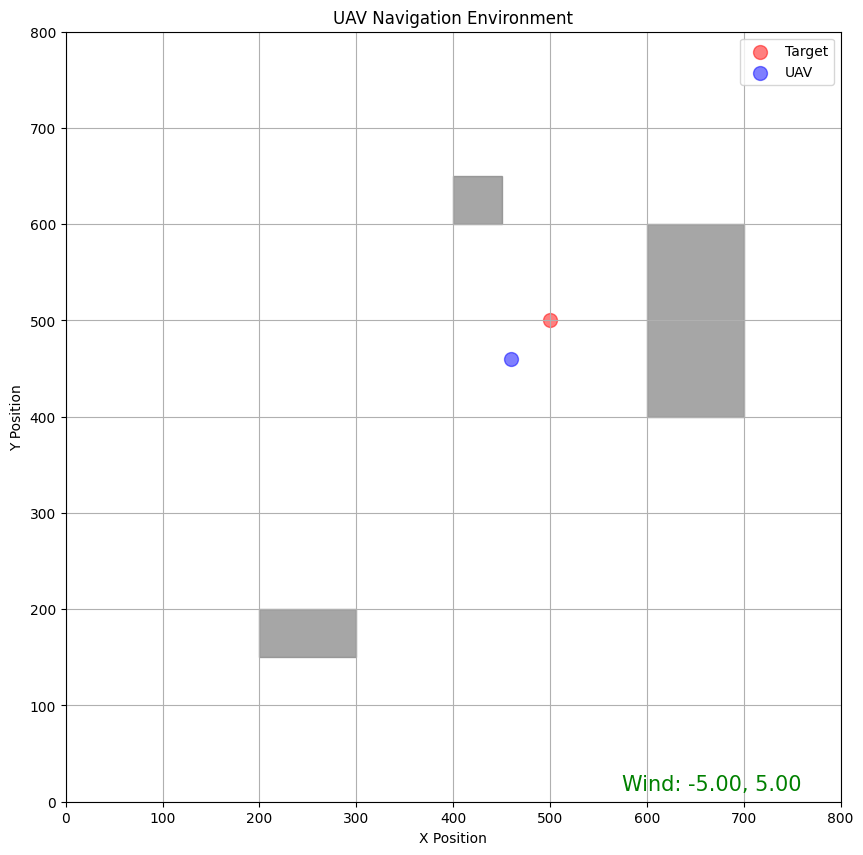

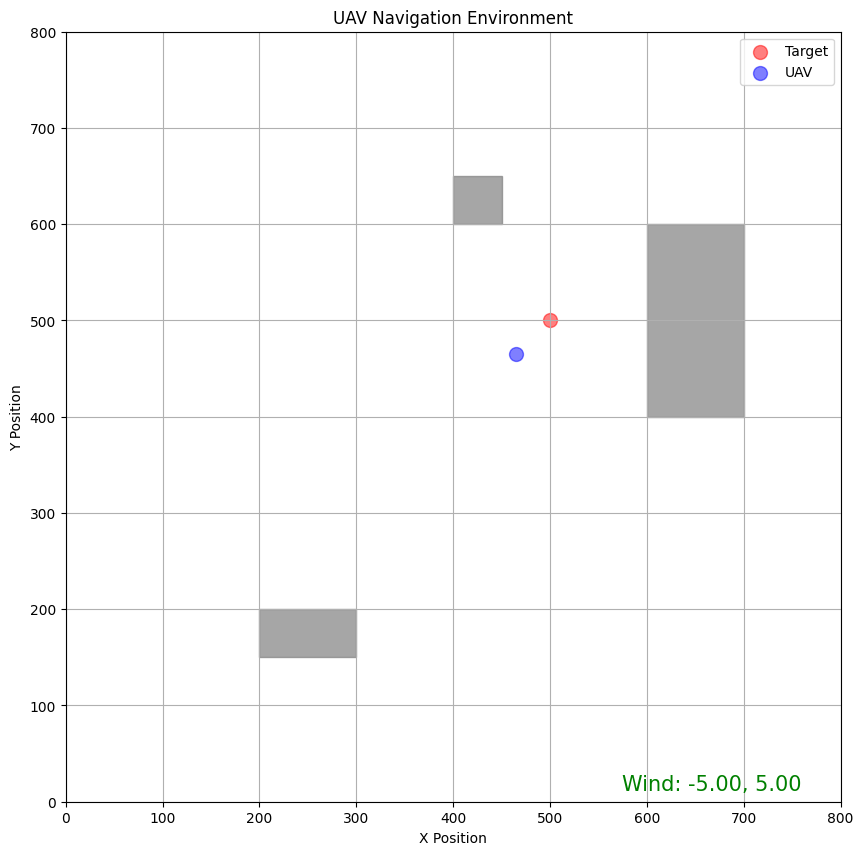

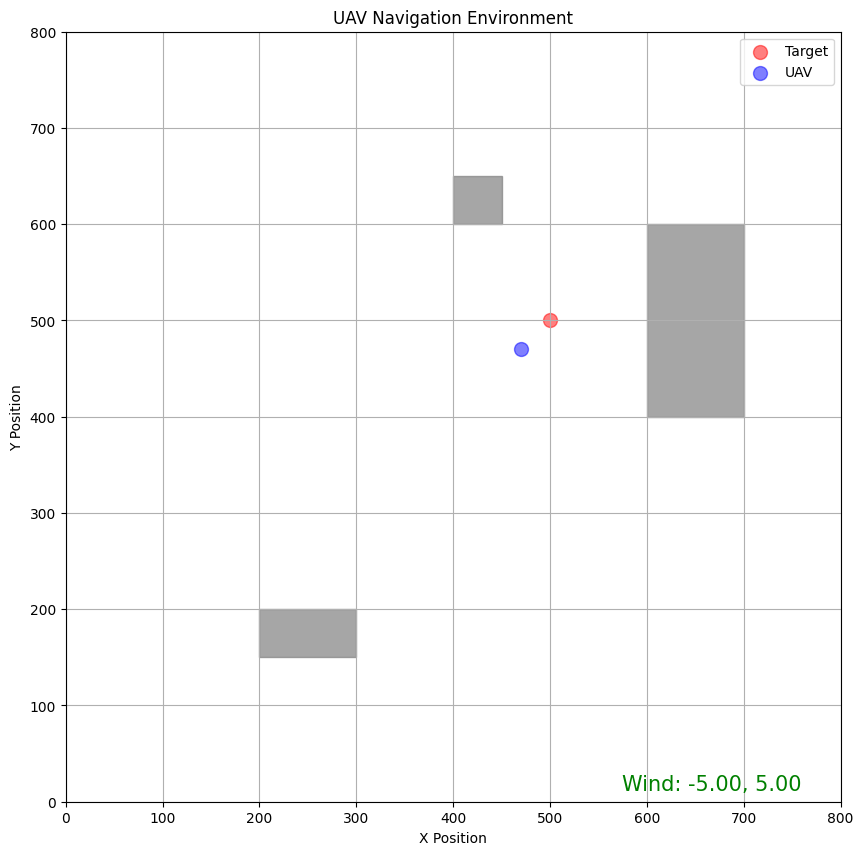

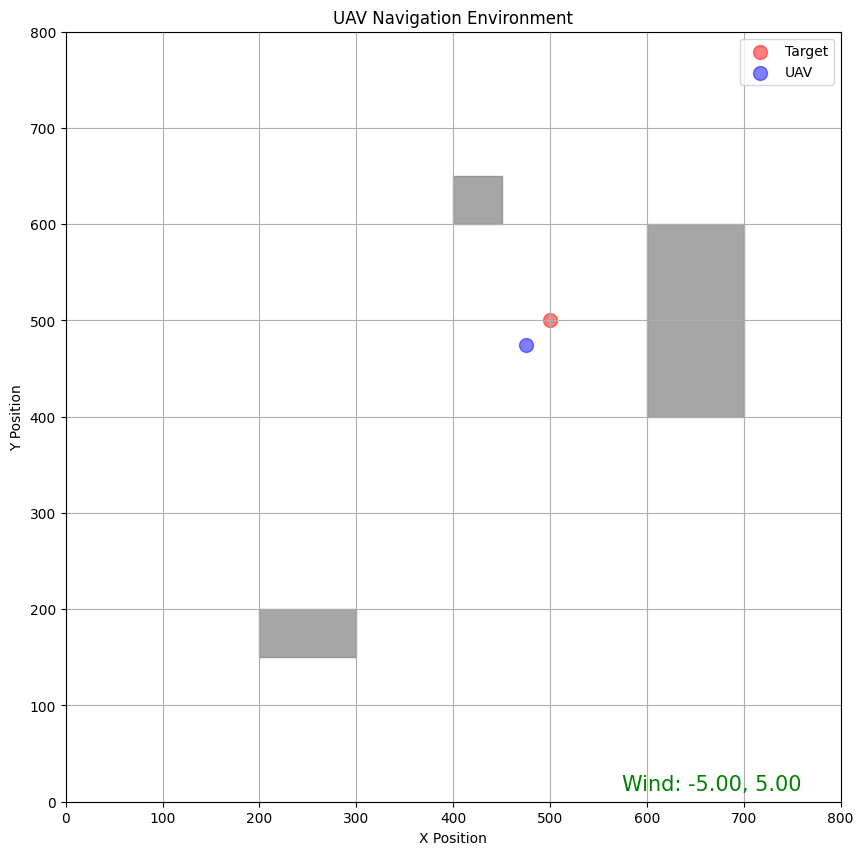

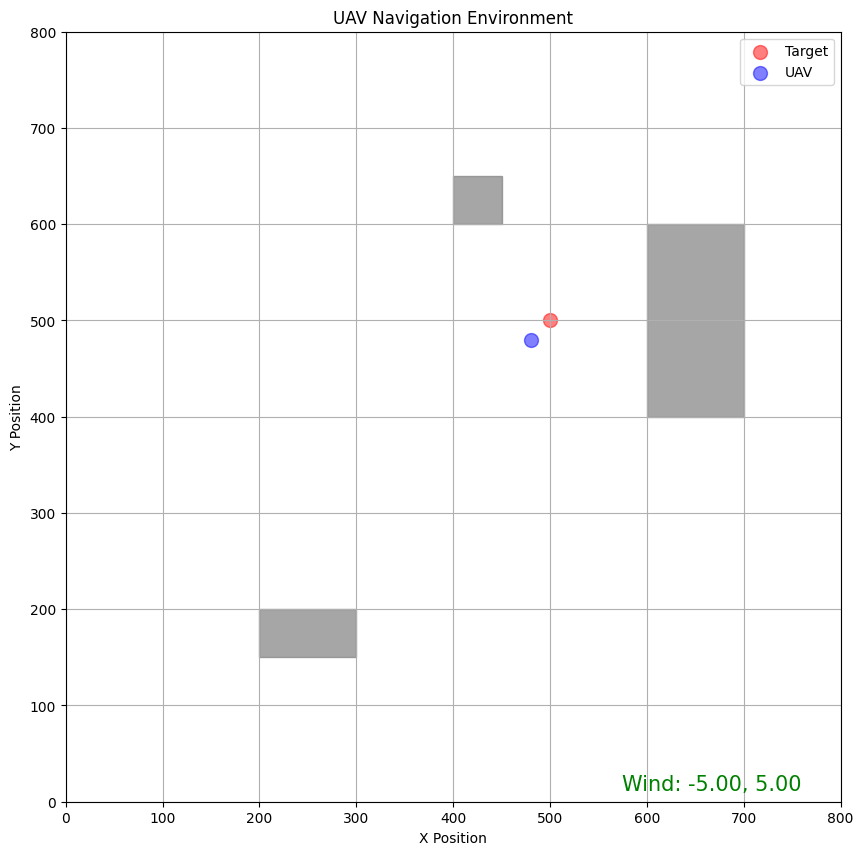

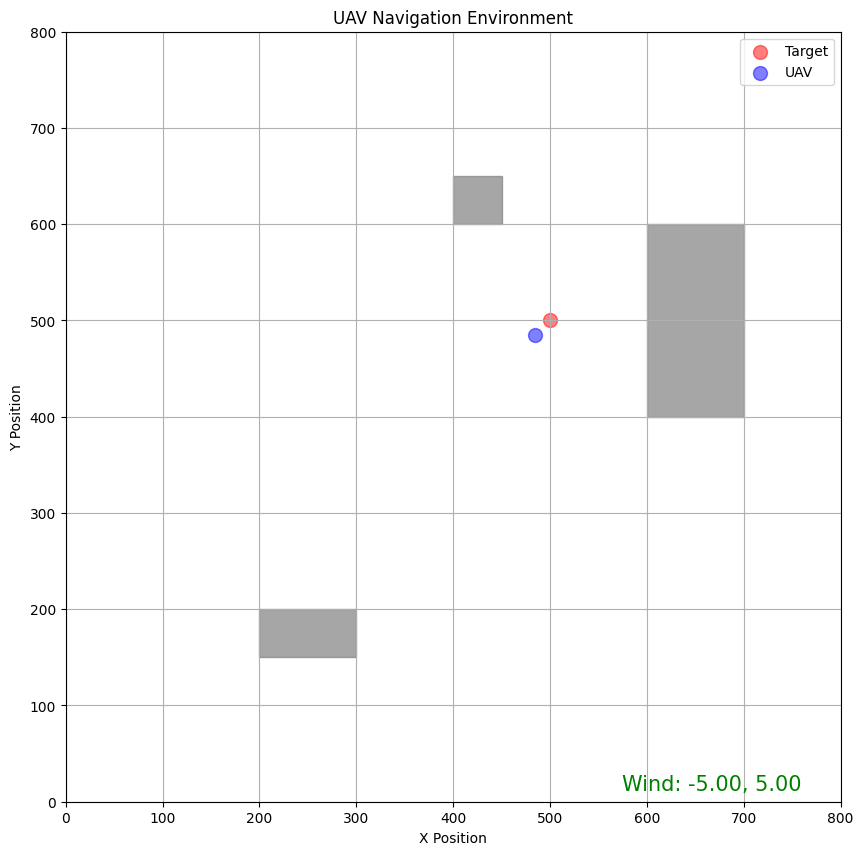

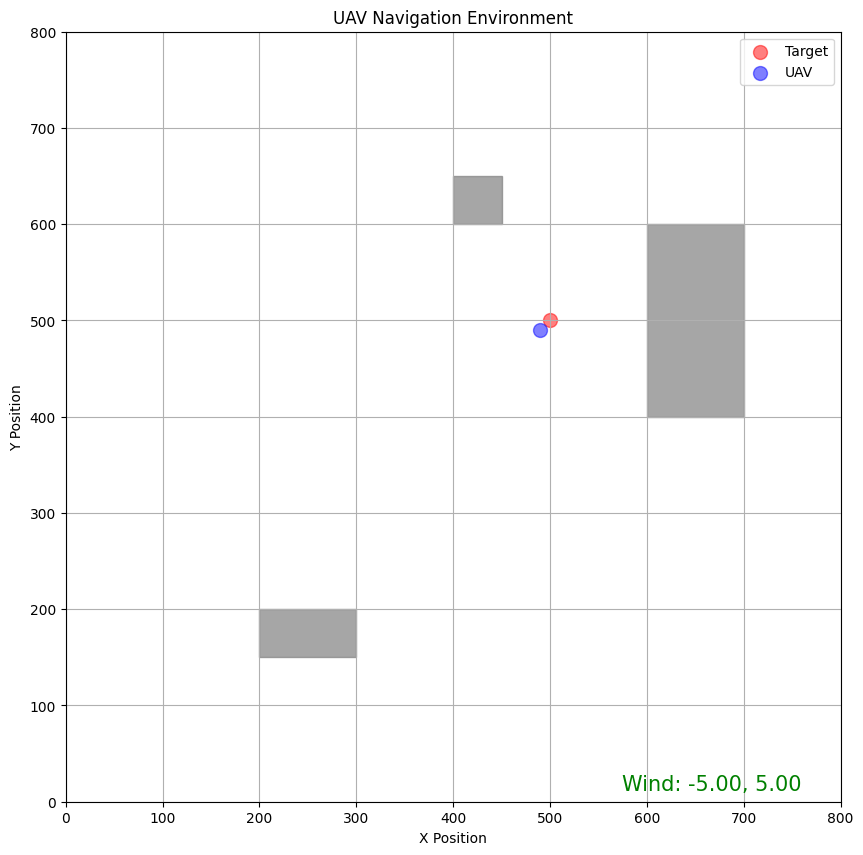

Episode finished after 79 timesteps


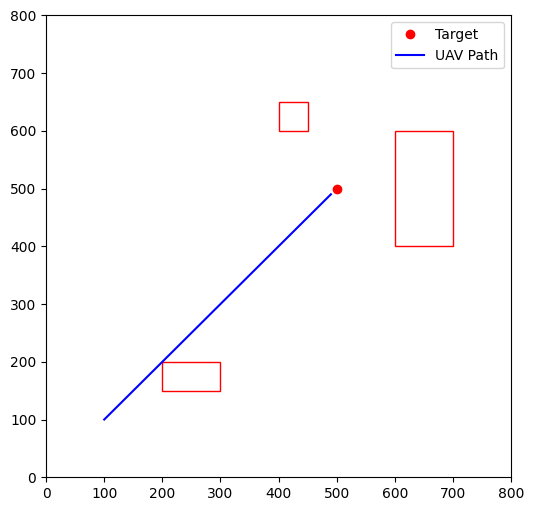

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# Create a single environment instance for testing
test_env = UAVEnv()

# Reset the environment and get the initial observation
obs = test_env.reset()

# Prepare to collect UAV's path for visualization
path_x, path_y = [], []

# Set the number of steps you want to watch
num_steps = 200

for step in range(num_steps):
    # Append current UAV position to path
    path_x.append(obs[0])
    path_y.append(obs[1])
    
    # Render the environment
    test_env.render()
    
    # Predict the action with the highest probability using your model
    action, _ = model.predict(obs, deterministic=True)
    
    # Take the action in the environment
    obs, reward, done, info = test_env.step(action)
    
    # Break the loop if the episode is done
    if done:
        print("Episode finished after {} timesteps".format(step + 1))
        break
    
    # Pause a bit between frames for easier visualization
    time.sleep(0.05)

# Close the environment properly if the environment has a close method
if hasattr(test_env, 'close'):
    test_env.close()

# Plotting the UAV's path after the run
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim((0, test_env.env_bounds[0]))
ax.set_ylim((0, test_env.env_bounds[1]))

# Plot target position
ax.plot(test_env.target_pos[0], test_env.target_pos[1], 'ro', label='Target')

# Plot obstacles
for (x, y), width, height in test_env.obstacles:
    ax.add_patch(patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none'))

# Plot UAV path
ax.plot(path_x, path_y, 'b-', label='UAV Path')  # UAV path as a blue line
ax.legend()

plt.show()


### Creating and Saving a UAV Path Animation

This script enhances the UAV navigation visualization by creating and saving an animation of the UAV's path as it maneuvers around obstacles towards a target. Here's a step-by-step breakdown:

- **Plot Setup**:
  - A figure and axes are set up using `matplotlib`'s `plt.subplots()`, with specified dimensions to ensure clarity.

- **Update Function**:
  - `update(frame)`: A function defined to update the plot for each frame of the animation.
  - Within this function:
    - The axes are cleared to reset the plot for the new frame.
    - The plot boundaries are set according to the environment's dimensions.
    - The target and obstacles are re-plotted. Obstacles are represented as non-filled rectangles.
    - The UAV's path up to the current frame is plotted as a blue line, showing its trajectory over time.
    - Each frame of the plot is captured as an image using `matplotlib`'s canvas buffer, converted to a NumPy array, and then transformed into a PIL Image.

- **Animation Creation**:
  - A list comprehension generates a sequence of PIL Images by calling `update(frame)` for each timestep of the episode.
  - This series of images represents each frame of the animation.

- **Saving the Animation**:
  - The first frame is used to initiate a GIF file, with subsequent frames appended.
  - The `save_all=True` parameter in the `save()` method ensures all frames are included in the GIF.
  - The `duration=100` sets the time each frame is displayed in milliseconds, controlling the speed of the animation.
  - The `loop=0` parameter ensures the animation does not loop.

- **Displaying the Final Path**:
  - After saving, the final path taken by the UAV is displayed as a static plot, providing a visual summary of the trajectory.

This method of visualization not only aids in understanding the UAV's decision-making and path optimization over time but also provides a useful tool for presentations or further analysis. The saved GIF can be easily shared or embedded in documentation.



C:\Users\ammar\AppData\Local\Temp\ipykernel_3488\3225584786.py:27: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


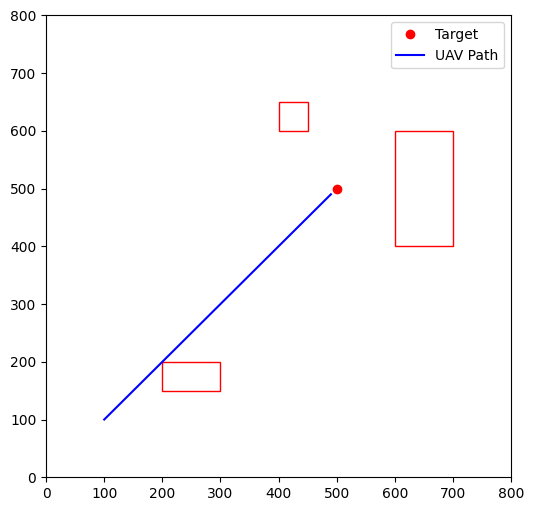

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# ... (Your existing code for creating the UAV path plot)

# Create a function to update the animation
def update(frame):
    ax.clear()
    ax.set_xlim((0, test_env.env_bounds[0]))
    ax.set_ylim((0, test_env.env_bounds[1]))

    # Plot target position
    ax.plot(test_env.target_pos[0], test_env.target_pos[1], 'ro', label='Target')

    # Plot obstacles
    for (x, y), width, height in test_env.obstacles:
        ax.add_patch(patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none'))

    # Plot UAV path up to the current frame
    ax.plot(path_x[:frame], path_y[:frame], 'b-', label='UAV Path')
    ax.legend()

    # Save the current frame as an image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return Image.fromarray(image)

# Create the animation
fig, ax = plt.subplots(figsize=(6, 6))
frames = [update(frame) for frame in range(num_steps)]

# Save the animation as a .gif
frames[0].save('uav_path_animation.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

plt.show()
